# **Sambriddhi Shrestha**

# **Bengali Sign Language Classification Using Convolutional Neural Networks and Transfer Learning with ResNet50 and InceptionV3**

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.model_selection import train_test_split
import shutil
from PIL import Image
import random

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

2025-05-11 04:30:50.821889: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746937851.087251      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746937851.161036      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
original_path = '/kaggle/input/signlanguagedetection/Sign Language Classification/Train'
train_dir = '/kaggle/working/signlanguagedetection/Sign Language Classification/Train'
if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
shutil.copytree(original_path,train_dir)

'/kaggle/working/signlanguagedetection/Sign Language Classification/Train'

In [3]:
# Create a new directory to store only validation images
val_dir = '/kaggle/working/signlanguagedetection/Sign Language Classification/Validation'
# Create a new directory to store only test images
test_dir = '/kaggle/working/signlanguagedetection/Sign Language Classification/SplitTest'
# Create a new directory to store only the selected classes
selected_classes_dir = '/kaggle/working/signlanguagedetection/Sign Language Classification/SelectedClasses'

In [4]:
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
os.makedirs(selected_classes_dir, exist_ok=True)

In [5]:
img_height, img_width = 224, 224
batch = 32
min_images_per_class = 1000

# Task 1: Data Understanding, Analysis, Visualization and Cleaning

### •What does the dataset represent? Provide a brief description.
### • How many total images are in the dataset?
### • What is the distribution of images across different classes?
### • How is the dataset split into training and validation sets? Justify your choice.
### • What preprocessing techniques (e.g., resizing, normalization) were applied?
### • What data generators, if any, were used for preprocessing and augmentation?
### • If data augmentation was applied, provide visualizations of sample augmented images.

### 1. What does the dataset represent? Provide a brief description.

The dataset choosen for the sign language classification represents alphabets in Bengali Sign Language. The main directory contains a train folder and a test folder. The train folder contains 38 subdirectories, each representing the 38 classes/alphabets and the test directory contains 3 unlabelled images.

### 2. How many total images are in the dataset?
### 3. What is the distribution of images across different classes?

In [6]:
# list of directories in the original train dataset
class_dirs = os.listdir(train_dir)

# dictionary to store class-wise image counts
class_image_counts = {}
total_images_count = 0
# iterate through each class directory again
for class_name in class_dirs:
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        count = 0
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)

            # count only valid image formats
            if image_path.lower().endswith(('jpg', 'jpeg', 'png', 'gif')):
                count += 1
                total_images_count += 1
        class_image_counts[class_name] = count

# print the count of images per class
print (f"Total images is the train folder: {total_images_count}")
print("Distribution of images across different classes in the original train dataset:")
for class_name, count in class_image_counts.items():
    print(f"Class '{class_name}' has {count} images.")

Total images is the train folder: 11058
Distribution of images across different classes in the original train dataset:
Class '30' has 292 images.
Class '35' has 286 images.
Class '12' has 284 images.
Class '4' has 246 images.
Class '5' has 294 images.
Class '28' has 291 images.
Class '25' has 294 images.
Class '2' has 298 images.
Class '8' has 297 images.
Class '37' has 296 images.
Class '17' has 293 images.
Class '29' has 292 images.
Class '22' has 300 images.
Class '26' has 292 images.
Class '3' has 286 images.
Class '19' has 295 images.
Class '34' has 290 images.
Class '11' has 291 images.
Class '7' has 289 images.
Class '13' has 286 images.
Class '31' has 295 images.
Class '14' has 277 images.
Class '23' has 292 images.
Class '6' has 291 images.
Class '15' has 294 images.
Class '21' has 293 images.
Class '16' has 298 images.
Class '27' has 293 images.
Class '9' has 292 images.
Class '24' has 297 images.
Class '0' has 293 images.
Class '1' has 294 images.
Class '36' has 289 images.


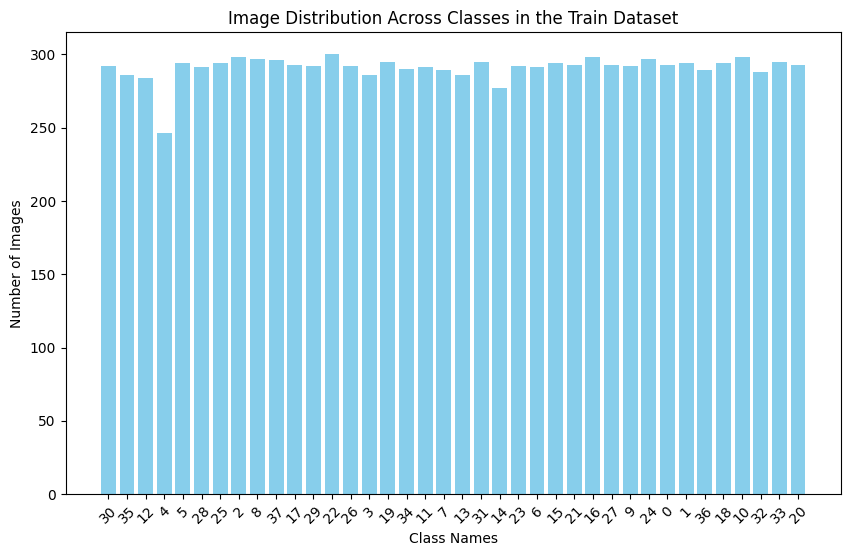

In [7]:
import matplotlib.pyplot as plt

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.bar(class_image_counts.keys(), class_image_counts.values(), color='skyblue')
plt.xlabel('Class Names')
plt.ylabel('Number of Images')
plt.title('Image Distribution Across Classes in the Train Dataset')
plt.xticks(rotation=45)
plt.show()

In [8]:
# Function to verify and clean corrupt images
def verify_images(directory):
    corrupt_images_count = 0 # count the total number of corrupted images
    print("Verifying images for corruption...")
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if not os.path.isdir(class_path):
            continue
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            try:
                # First, check if the file is a valid image 
                with Image.open(img_path) as img: 
                    img.verify()  # Check image integrity 
                # Reopen to check if it can be loaded as an array 
                img = load_img(img_path) 
                img.close()
            
            except Exception as e:
                corrupt_images_count += 1
                print(f"Removing corrupt image: {img_path} ({e})")
                os.remove(img_path)
    print(f"Total corrupted images in the original : {corrupt_images_count}")

In [9]:
# Function to select 10 classes (3 fixed + 7 random)
def select_classes(source_dir, target_dir, fixed_classes=['0', '14', '29']):
    print("Selecting 10 classes...")
    class_dirs = [d for d in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, d))]
    
    # Check if fixed classes exist
    for cls in fixed_classes:
        if cls not in class_dirs:
            raise ValueError(f"Class '{cls}' not found in {source_dir}.")
    
    # Remove fixed classes from the pool
    remaining_classes = [cls for cls in class_dirs if cls not in fixed_classes]
    
    # Randomly select 7 more classes
    random_classes = random.sample(remaining_classes, 7)
    
    # Combine fixed and random classes
    selected_classes = fixed_classes + random_classes
    print("Selected classes:", selected_classes)
    
    # Copy selected class directories to target_dir
    for cls in selected_classes:
        src_path = os.path.join(source_dir, cls)
        dst_path = os.path.join(target_dir, cls)
        if os.path.exists(src_path):
            shutil.copytree(src_path, dst_path, dirs_exist_ok=True)
        else:
            print(f"Class {cls} not found at {src_path}. Skipping.")
    
    return selected_classes

In [10]:
# Function to select 10 fixed classes
def select_fixed_classes(source_dir, target_dir, fixed_classes=['0', '14', '29', '23', '18', '22', '5', '30', '16', '12']):
    print("Selecting 10 classes...")

    # Check if fixed classes exist
    class_dirs = [d for d in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, d))]
    for cls in fixed_classes:
        if cls not in class_dirs:
            raise ValueError(f"Class '{cls}' not found in {source_dir}.")

    print("Selected classes:", fixed_classes)
    
    # Copy selected class directories to target_dir
    for cls in fixed_classes:
        src_path = os.path.join(source_dir, cls)
        dst_path = os.path.join(target_dir, cls)
        if os.path.exists(src_path):
            shutil.copytree(src_path, dst_path, dirs_exist_ok=True)
            print(f"Copied class '{cls}' to '{target_dir}'.")
        else:
            print(f"Class {cls} not found at {src_path}. Skipping.")
    
    return fixed_classes

### 4. How is the dataset split into training and validation sets? Justify your choice.

In [11]:
# Function to split dataset into train, validation, and test sets
def split_dataset(source_dir, val_dir, test_dir, train_split=0.7, val_split=0.2):
    print("Splitting dataset...")
    for class_name in os.listdir(source_dir):
        class_path = os.path.join(source_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        # Get all image files
        images = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
        if not images:
            print(f"No images found in class {class_name}. Skipping.")
            continue

        # Split images
        train_images, temp_images = train_test_split(images, train_size=train_split, random_state=42)
        val_split_ratio = val_split / (val_split + 0.1)
        val_images, test_images = train_test_split(temp_images, train_size=val_split_ratio, random_state=42)

        print(f"Class {class_name}: Train={len(train_images)}, Val={len(val_images)}, Test={len(test_images)}")

        # Create class directories in validation and test sets
        os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

        # Move validation images
        for img in val_images:
            src = os.path.join(class_path, img)
            dst = os.path.join(val_dir, class_name, img)
            shutil.move(src, dst)

        # Move test images
        for img in test_images:
            src = os.path.join(class_path, img)
            dst = os.path.join(test_dir, class_name, img)
            shutil.move(src, dst)

In [15]:
# Display augmented images
def display_augmented_images(images, augmented_images):
    plt.figure(figsize=(10, 5))
    for i in range(5):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].astype('uint8'))
        plt.title("Original")
        plt.axis('off')
        
        plt.subplot(2, 5, i + 6)
        plt.imshow(augmented_images[i].astype('uint8'))
        plt.title("Augmented")
        plt.axis('off')
    plt.show()

In [13]:
# Function to augment training data to reach min_images_per_class
def augment_data_to_disk(source_dir, min_per_class=1000):
    print("Augmenting training data...")
    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    for class_name in os.listdir(source_dir):
        class_path = os.path.join(source_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        # Count existing images
        existing_files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
        num_existing = len(existing_files)
        print(f"Class {class_name}: {num_existing} images")

        if num_existing >= min_per_class:
            print(f"Class {class_name} already has {num_existing} images. Skipping.")
            continue

        num_to_generate = min_per_class - num_existing
        print(f"Generating {num_to_generate} additional images for {class_name}")

        # Load a batch of images
        image_files = [os.path.join(class_path, f) for f in existing_files]
        images_to_augment = []
        for img_path in image_files[:min(100, len(image_files))]:  # Use up to 100 source images
            try:
                img = load_img(img_path, target_size=(img_height, img_width))
                img_array = img_to_array(img)
                images_to_augment.append(img_array)
            except Exception as e:
                print(f"Error loading {img_path}: {e}")

        if not images_to_augment:
            print(f"No valid images in class {class_name}. Skipping.")
            continue

        images_to_augment = np.array(images_to_augment)

        # Generate augmented images (without saving) for visualization
        augmented_images = [datagen.random_transform(img) for img in images_to_augment]
        display_augmented_images(images_to_augment, augmented_images)

        # Save augmented images to disk
        aug_iter = datagen.flow(
            images_to_augment,
            batch_size=len(images_to_augment),
            save_to_dir=class_path,
            save_prefix=f'aug_{class_name}',
            save_format='jpg'
        )

        batches_needed = int(np.ceil(num_to_generate / len(images_to_augment)))
        for i in range(batches_needed):
            next(aug_iter)  # Save batch to disk
            current_count = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
            print(f"Class {class_name}: Batch {i+1}/{batches_needed}. Now {current_count} images.")
            if current_count >= min_per_class:
                break

In [14]:
# Function to count images per class
def count_images(directory):
    counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            counts[class_name] = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
    return counts

In [17]:
def visualize_class_distribution(counts, dataset_name):
    # Prepare data for plotting
    classes = list(counts.keys())
    num_images = list(counts.values())

    # Plotting the bar chart
    plt.figure(figsize=(12, 8))
    plt.bar(classes, num_images, color='lightblue')
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.title(f'Class Distribution in {dataset_name} Dataset')
    plt.xticks(rotation=45, ha='right')

    # Adding data labels on top of each bar
    for i, count in enumerate(num_images):
        plt.text(i, count + 5, str(count), ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()


### 5. What preprocessing techniques (e.g., resizing, normalization) were applied?
### 6. What data generators, if any, were used for preprocessing and augmentation?

In [13]:
# Main preprocessing pipeline
def main():
    # A local variable to track the working directory
    working_dir = train_dir  # Start with the original train_dir

    # Step 1: Verify and clean corrupt images in Train directory
    verify_images(working_dir)

    # Step 2: Check if class selection is needed
    class_dirs = [d for d in os.listdir(working_dir) if os.path.isdir(os.path.join(working_dir, d))]
    if len(class_dirs) > 10:
        print(f"Found {len(class_dirs)} classes. Selecting 10 classes...")
        select_classes(working_dir, selected_classes_dir, fixed_classes=['0', '14', '29'])
        working_dir = selected_classes_dir  # Update to selected classes directory
    else:
        print(f"Found {len(class_dirs)} classes. Assuming these are the selected classes.")

    # Step 3: Count initial images per class
    print("Initial image counts:", count_images(working_dir))

    # Step 4: Split dataset
    split_dataset(working_dir, val_dir, test_dir, train_split=0.7, val_split=0.2)

    # Step 5: Count images after splitting
    print("Training image counts:", count_images(working_dir))
    print("Validation image counts:", count_images(val_dir))
    print("Test image counts:", count_images(test_dir))

    # Step 6: Augment training data
    augment_data_to_disk(working_dir, min_per_class=min_images_per_class)

    # Step 7: Final training image counts
    print("Final training image counts:", count_images(working_dir))

    # Step 8: Set up data generators for verification
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    val_test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        working_dir,
        target_size=(img_height, img_width),
        batch_size=batch,
        class_mode='sparse',
        seed=42
    )

    val_generator = val_test_datagen.flow_from_directory(
        val_dir,
        target_size=(img_height, img_width),
        batch_size=batch,
        class_mode='sparse',
        shuffle=False,
        seed=42
    )

    test_generator = val_test_datagen.flow_from_directory(
        test_dir,
        target_size=(img_height, img_width),
        batch_size=batch,
        class_mode='sparse',
        shuffle=False,
        seed=42
    )

    print("Class indices:", train_generator.class_indices)

In [18]:
# Main preprocessing pipeline
def main():
    # A local variable to track the working directory
    working_dir = train_dir  # Start with the original train_dir

    # Step 1: Verify and clean corrupt images in Train directory
    verify_images(working_dir)

    # Step 2: Check if class selection is needed
    class_dirs = [d for d in os.listdir(working_dir) if os.path.isdir(os.path.join(working_dir, d))]
    if len(class_dirs) > 10:
        print(f"Found {len(class_dirs)} classes. Selecting 10 classes...")
        select_fixed_classes(working_dir, selected_classes_dir, fixed_classes=['0', '14', '29', '23', '18', '22', '5', '30', '16', '12'])
        working_dir = selected_classes_dir  # Update to selected classes directory
    else:
        print(f"Found {len(class_dirs)} classes. Assuming these are the selected classes.")

    # Step 3: Count initial images per class
    print("Initial image counts:", count_images(working_dir))

    # Step 4: Split dataset
    split_dataset(working_dir, val_dir, test_dir, train_split=0.7, val_split=0.2)

    # Step 5: Count images after splitting and Visualize distribution
    train_counts = count_images(working_dir)
    val_counts = count_images(val_dir)
    test_counts = count_images(test_dir)
    print("Training image counts:", train_counts)
    print("Visualizing Training Dataset:")
    visualize_class_distribution(train_counts, "Training")
    
    print("Validation image counts:", val_counts)
    print("Visualizing Validation Dataset:")
    visualize_class_distribution(val_counts, "Validation")
    
    print("Test image counts:", test_counts)
    print("Visualizing Testing Dataset:")
    visualize_class_distribution(test_counts, "Testing")

    # Step 6: Augment training data
    augment_data_to_disk(working_dir, min_per_class=min_images_per_class)

    # Step 7: Final training image counts
    final_training_counts = count_images(working_dir)
    print("Final training image counts:", final_training_counts)
    print("Visualizing Training Dataset:")
    visualize_class_distribution(final_training_counts, "Final Training")    

    # Step 8: Set up data generators for verification
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    val_test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        working_dir,
        target_size=(img_height, img_width),
        batch_size=batch,
        class_mode='sparse',
        seed=42
    )

    val_generator = val_test_datagen.flow_from_directory(
        val_dir,
        target_size=(img_height, img_width),
        batch_size=batch,
        class_mode='sparse',
        shuffle=False,
        seed=42
    )

    test_generator = val_test_datagen.flow_from_directory(
        test_dir,
        target_size=(img_height, img_width),
        batch_size=batch,
        class_mode='sparse',
        shuffle=False,
        seed=42
    )

    print("Class indices:", train_generator.class_indices)

### 7. If data augmentation was applied, provide visualizations of sample augmented images.

Verifying images for corruption...
Removing corrupt image: /kaggle/working/signlanguagedetection/Sign Language Classification/Train/30/DSC_0640.JPG (cannot identify image file '/kaggle/working/signlanguagedetection/Sign Language Classification/Train/30/DSC_0640.JPG')
Removing corrupt image: /kaggle/working/signlanguagedetection/Sign Language Classification/Train/30/DSC_1687.JPG (cannot identify image file '/kaggle/working/signlanguagedetection/Sign Language Classification/Train/30/DSC_1687.JPG')
Removing corrupt image: /kaggle/working/signlanguagedetection/Sign Language Classification/Train/30/IMG_20180702_100133.jpg (cannot identify image file '/kaggle/working/signlanguagedetection/Sign Language Classification/Train/30/IMG_20180702_100133.jpg')
Removing corrupt image: /kaggle/working/signlanguagedetection/Sign Language Classification/Train/30/DSC_1078.JPG (cannot identify image file '/kaggle/working/signlanguagedetection/Sign Language Classification/Train/30/DSC_1078.JPG')
Removing co

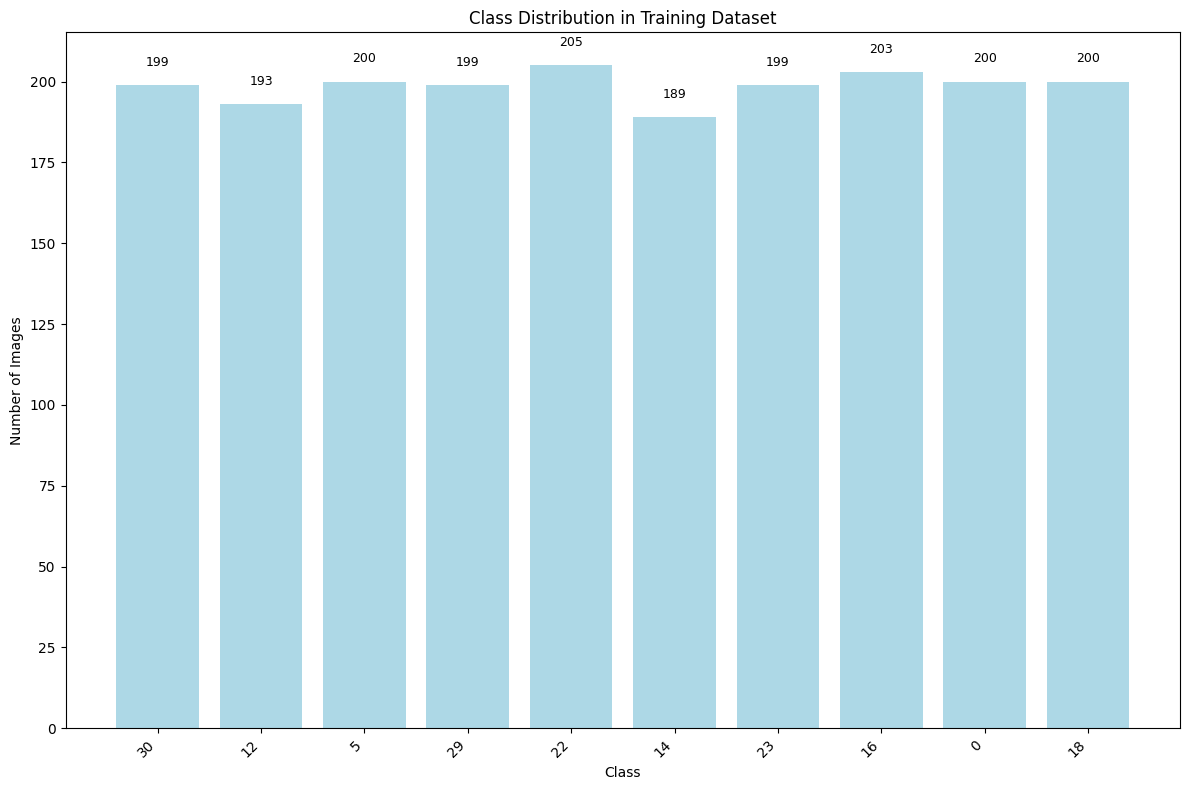

Validation image counts: {'30': 57, '12': 56, '5': 58, '29': 57, '22': 58, '14': 54, '23': 57, '16': 58, '0': 57, '18': 58}
Visualizing Validation Dataset:


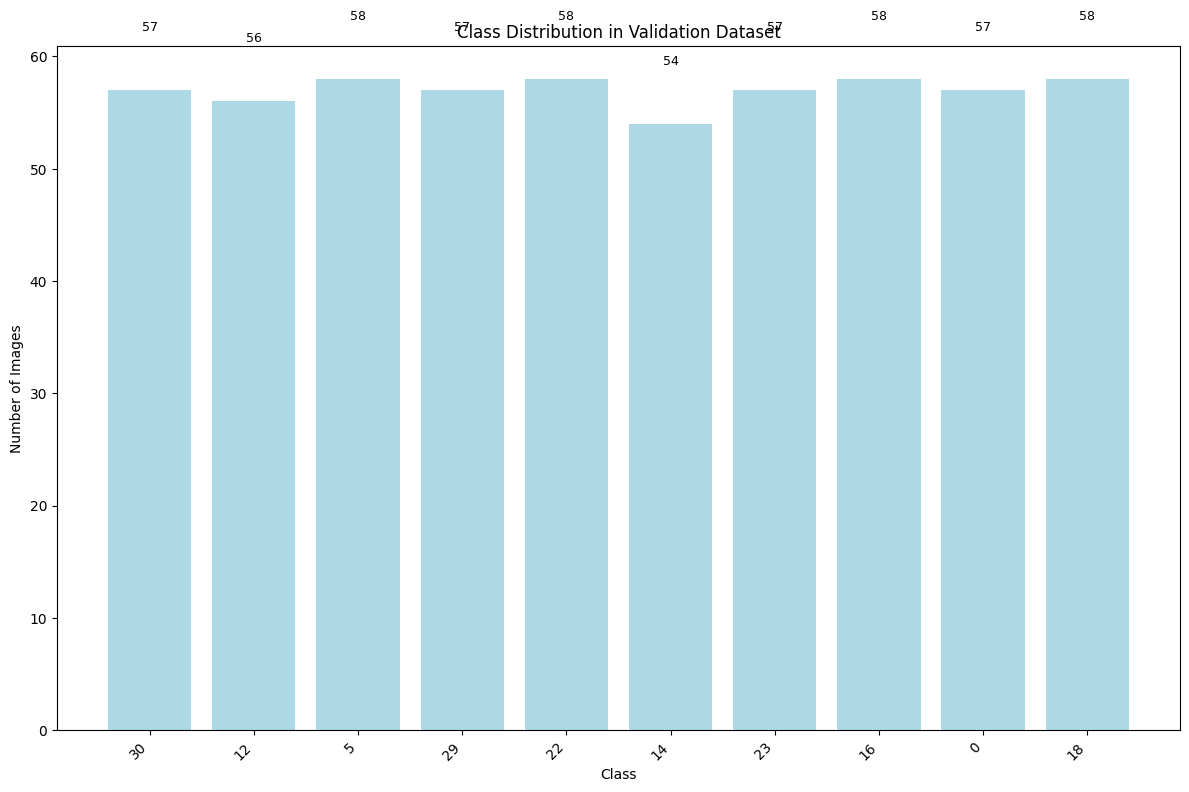

Test image counts: {'30': 29, '12': 28, '5': 29, '29': 29, '22': 30, '14': 27, '23': 29, '16': 30, '0': 29, '18': 29}
Visualizing Testing Dataset:


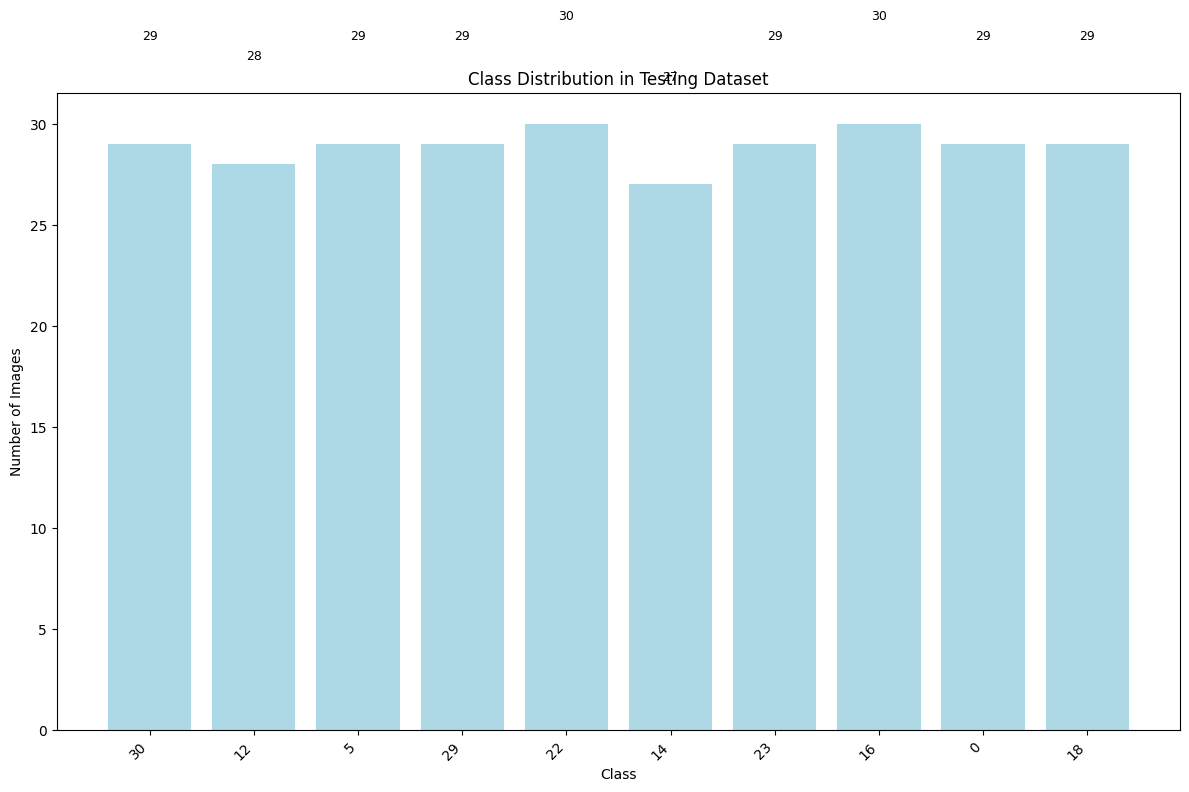

Augmenting training data...
Class 30: 199 images
Generating 801 additional images for 30


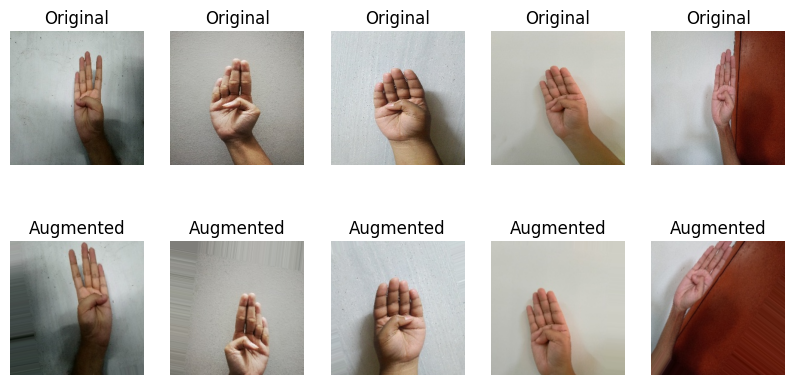

Class 30: Batch 1/9. Now 299 images.
Class 30: Batch 2/9. Now 399 images.
Class 30: Batch 3/9. Now 499 images.
Class 30: Batch 4/9. Now 599 images.
Class 30: Batch 5/9. Now 699 images.
Class 30: Batch 6/9. Now 799 images.
Class 30: Batch 7/9. Now 899 images.
Class 30: Batch 8/9. Now 999 images.
Class 30: Batch 9/9. Now 1099 images.
Class 12: 193 images
Generating 807 additional images for 12


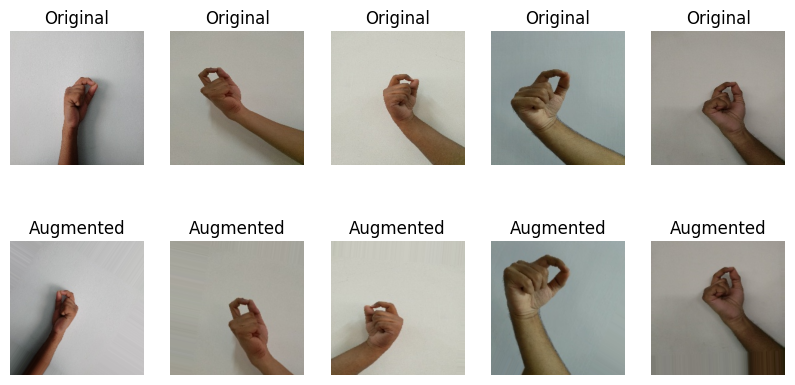

Class 12: Batch 1/9. Now 293 images.
Class 12: Batch 2/9. Now 393 images.
Class 12: Batch 3/9. Now 493 images.
Class 12: Batch 4/9. Now 592 images.
Class 12: Batch 5/9. Now 692 images.
Class 12: Batch 6/9. Now 792 images.
Class 12: Batch 7/9. Now 892 images.
Class 12: Batch 8/9. Now 992 images.
Class 12: Batch 9/9. Now 1092 images.
Class 5: 200 images
Generating 800 additional images for 5


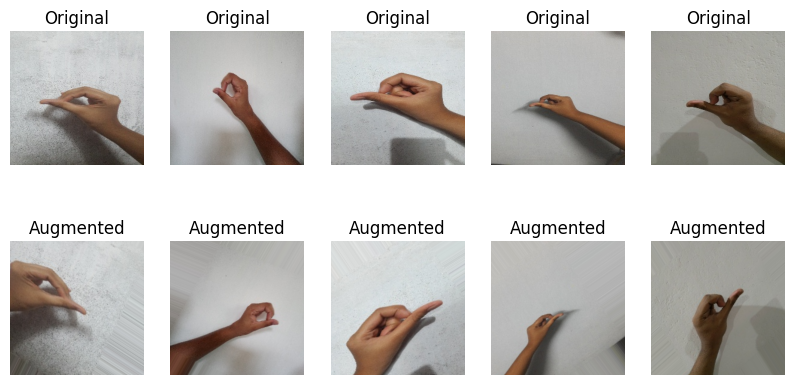

Class 5: Batch 1/8. Now 300 images.
Class 5: Batch 2/8. Now 400 images.
Class 5: Batch 3/8. Now 500 images.
Class 5: Batch 4/8. Now 600 images.
Class 5: Batch 5/8. Now 700 images.
Class 5: Batch 6/8. Now 800 images.
Class 5: Batch 7/8. Now 900 images.
Class 5: Batch 8/8. Now 1000 images.
Class 29: 199 images
Generating 801 additional images for 29


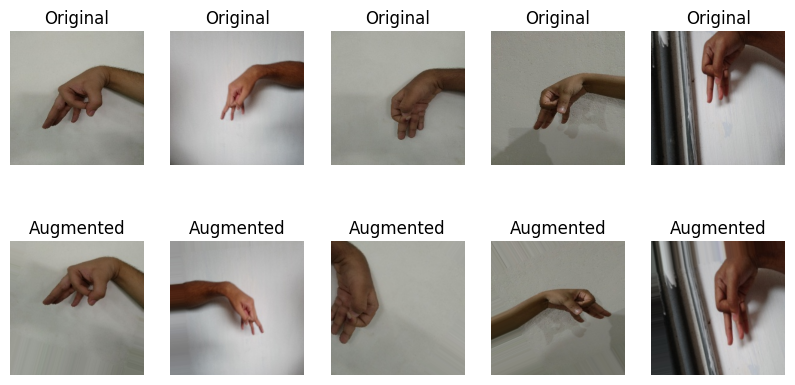

Class 29: Batch 1/9. Now 299 images.
Class 29: Batch 2/9. Now 399 images.
Class 29: Batch 3/9. Now 499 images.
Class 29: Batch 4/9. Now 599 images.
Class 29: Batch 5/9. Now 699 images.
Class 29: Batch 6/9. Now 799 images.
Class 29: Batch 7/9. Now 899 images.
Class 29: Batch 8/9. Now 999 images.
Class 29: Batch 9/9. Now 1099 images.
Class 22: 205 images
Generating 795 additional images for 22


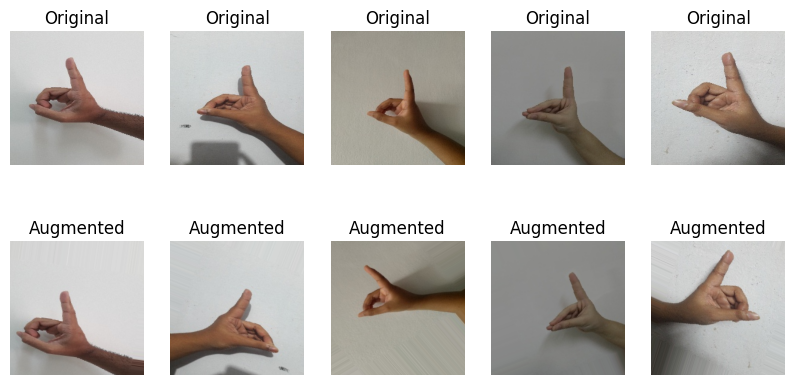

Class 22: Batch 1/8. Now 305 images.
Class 22: Batch 2/8. Now 405 images.
Class 22: Batch 3/8. Now 505 images.
Class 22: Batch 4/8. Now 605 images.
Class 22: Batch 5/8. Now 705 images.
Class 22: Batch 6/8. Now 805 images.
Class 22: Batch 7/8. Now 905 images.
Class 22: Batch 8/8. Now 1005 images.
Class 14: 189 images
Generating 811 additional images for 14


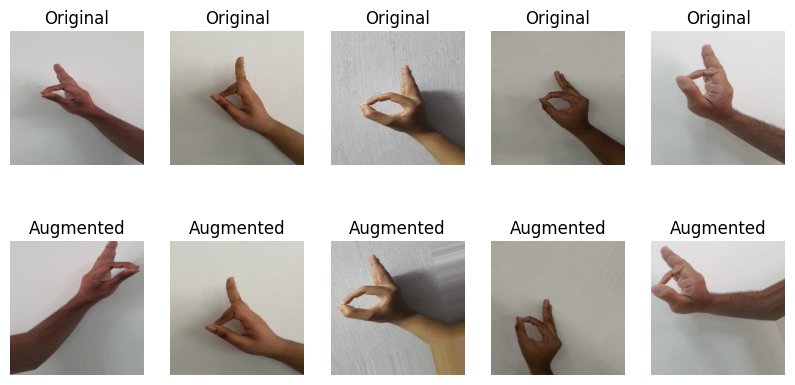

Class 14: Batch 1/9. Now 289 images.
Class 14: Batch 2/9. Now 389 images.
Class 14: Batch 3/9. Now 489 images.
Class 14: Batch 4/9. Now 589 images.
Class 14: Batch 5/9. Now 689 images.
Class 14: Batch 6/9. Now 789 images.
Class 14: Batch 7/9. Now 888 images.
Class 14: Batch 8/9. Now 988 images.
Class 14: Batch 9/9. Now 1088 images.
Class 23: 199 images
Generating 801 additional images for 23


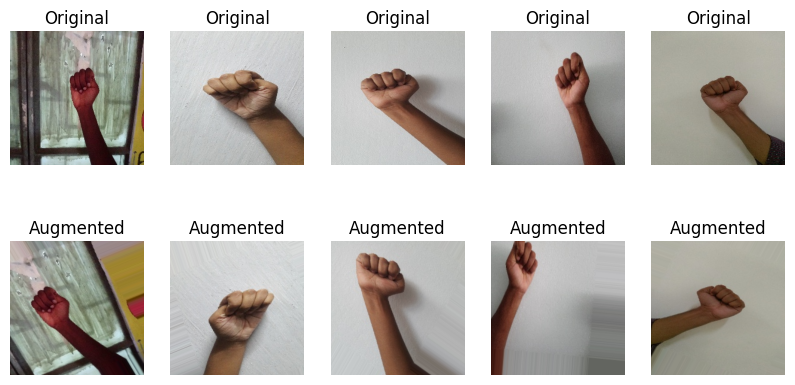

Class 23: Batch 1/9. Now 299 images.
Class 23: Batch 2/9. Now 399 images.
Class 23: Batch 3/9. Now 499 images.
Class 23: Batch 4/9. Now 599 images.
Class 23: Batch 5/9. Now 699 images.
Class 23: Batch 6/9. Now 799 images.
Class 23: Batch 7/9. Now 899 images.
Class 23: Batch 8/9. Now 999 images.
Class 23: Batch 9/9. Now 1099 images.
Class 16: 203 images
Generating 797 additional images for 16


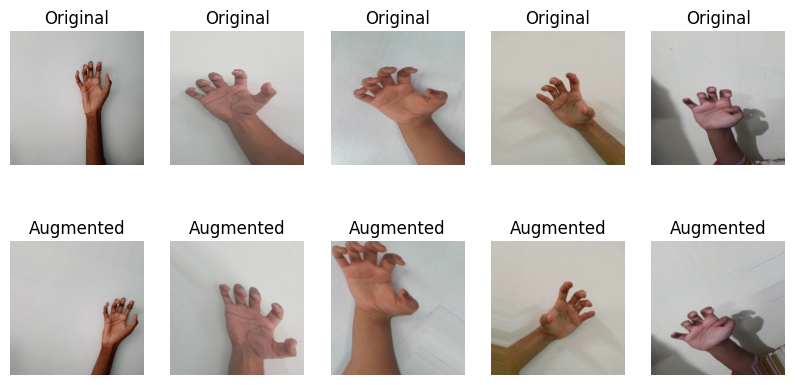

Class 16: Batch 1/8. Now 303 images.
Class 16: Batch 2/8. Now 403 images.
Class 16: Batch 3/8. Now 503 images.
Class 16: Batch 4/8. Now 603 images.
Class 16: Batch 5/8. Now 703 images.
Class 16: Batch 6/8. Now 803 images.
Class 16: Batch 7/8. Now 903 images.
Class 16: Batch 8/8. Now 1003 images.
Class 0: 200 images
Generating 800 additional images for 0


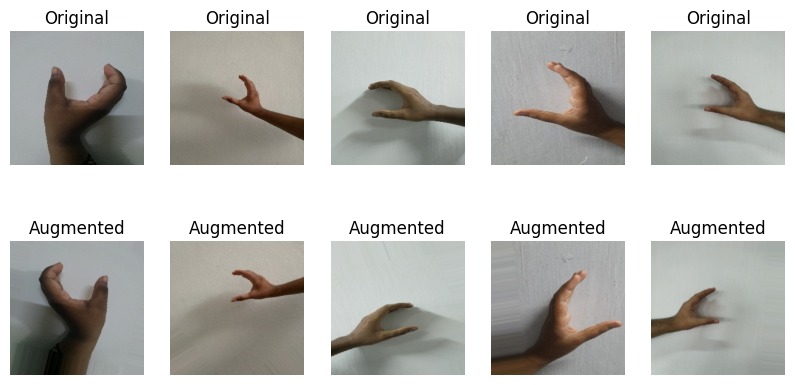

Class 0: Batch 1/8. Now 300 images.
Class 0: Batch 2/8. Now 400 images.
Class 0: Batch 3/8. Now 500 images.
Class 0: Batch 4/8. Now 600 images.
Class 0: Batch 5/8. Now 700 images.
Class 0: Batch 6/8. Now 800 images.
Class 0: Batch 7/8. Now 900 images.
Class 0: Batch 8/8. Now 1000 images.
Class 18: 200 images
Generating 800 additional images for 18


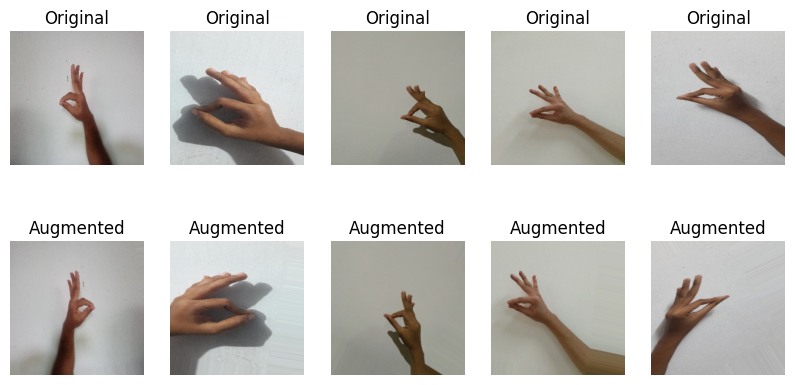

Class 18: Batch 1/8. Now 300 images.
Class 18: Batch 2/8. Now 400 images.
Class 18: Batch 3/8. Now 500 images.
Class 18: Batch 4/8. Now 600 images.
Class 18: Batch 5/8. Now 700 images.
Class 18: Batch 6/8. Now 800 images.
Class 18: Batch 7/8. Now 900 images.
Class 18: Batch 8/8. Now 999 images.
Final training image counts: {'30': 1099, '12': 1092, '5': 1000, '29': 1099, '22': 1005, '14': 1088, '23': 1099, '16': 1003, '0': 1000, '18': 999}
Visualizing Training Dataset:


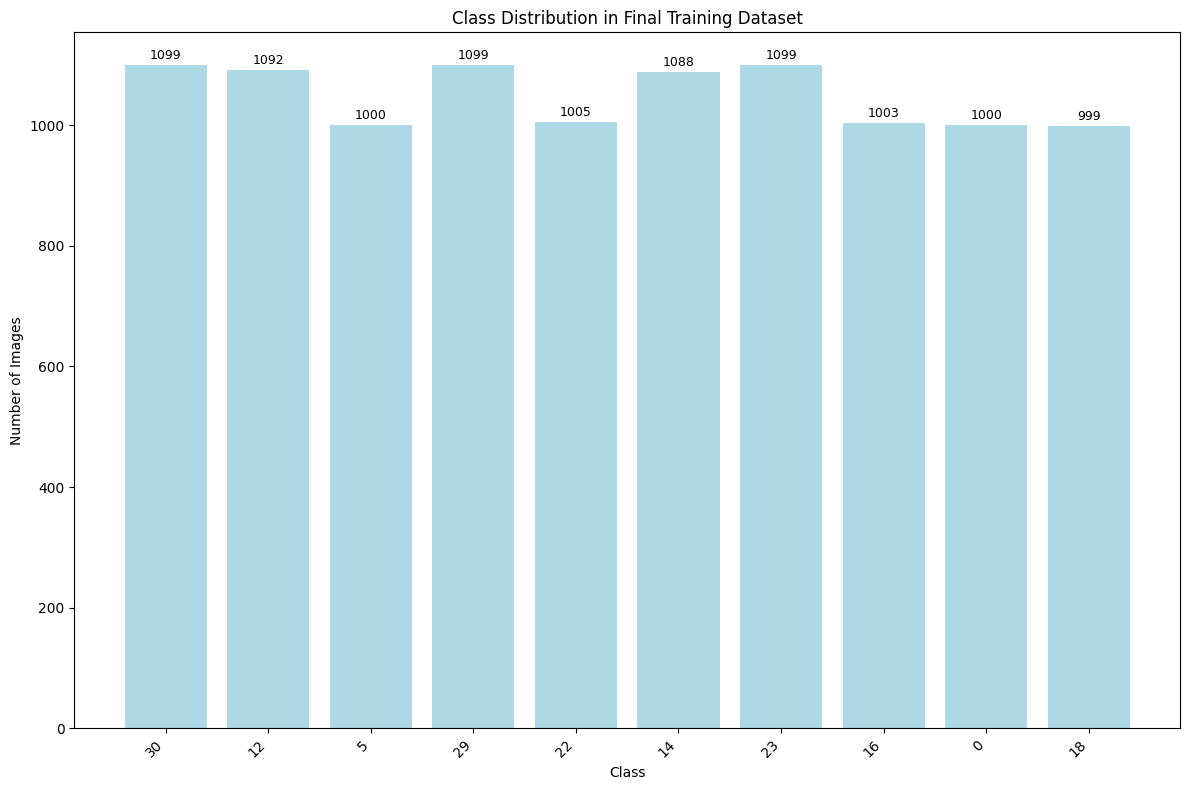

Found 10484 images belonging to 10 classes.
Found 570 images belonging to 10 classes.
Found 289 images belonging to 10 classes.
Class indices: {'0': 0, '12': 1, '14': 2, '16': 3, '18': 4, '22': 5, '23': 6, '29': 7, '30': 8, '5': 9}


In [19]:
if __name__ == "__main__":
    main()

In [85]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Input
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import time

# Paths
train_dir = '/kaggle/working/signlanguagedetection/Sign Language Classification/SelectedClasses'
val_dir = '/kaggle/working/signlanguagedetection/Sign Language Classification/Validation'
test_dir = '/kaggle/working/signlanguagedetection/Sign Language Classification/SplitTest'

In [20]:
image_counts = {}

for class_name in sorted(os.listdir(selected_classes_dir)):
    class_path = os.path.join(selected_classes_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    image_files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
    image_counts[class_name] = len(image_files)

# get min and max values
min_class = min(image_counts, key=image_counts.get)
max_class = max(image_counts, key=image_counts.get)

print(f"Class with minimum images: {min_class} with {image_counts[min_class]} images.")
print(f"Class with maximum images: {max_class} with {image_counts[max_class]} images")

Class with minimum images: 18 with 999 images.
Class with maximum images: 23 with 1099 images


In [82]:
# initialize a set to store unique image sizes
image_sizes = set()

# loop through all files in the directory
for root, dirs, files in os.walk(selected_classes_dir):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
            img_path = os.path.join(root, file)
            try:
                with Image.open(img_path) as img:
                    image_sizes.add(img.size)  # (width, height)
            except Exception as e:
                print(f"Error processing {img_path}: {e}")

# print all unique image sizes
print("Unique image sizes in the directory:")
for size in image_sizes:
    print(f"- {size[0]}x{size[1]}")

Unique image sizes in the directory:
- 224x224


In [21]:
def check_corrupted_images(directory):
    corrupted_files = []
    total_files = 0
    
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                total_files += 1
                file_path = os.path.join(root, file)
                try:
                    with Image.open(file_path) as img:
                        img.verify()  # This checks for corruption
                except Exception as e:
                    corrupted_files.append((file_path, str(e)))
    
    print(f"Checked {total_files} images in: {directory}")
    if corrupted_files:
        print(f"Found {len(corrupted_files)} corrupted images:")
        for file_path, error in corrupted_files:
            print(f"- {file_path} | Error: {error}")
    else:
        print("No corrupted images found ")


# Run the check
check_corrupted_images(val_dir)
check_corrupted_images(test_dir)

Checked 570 images in: /kaggle/working/signlanguagedetection/Sign Language Classification/Validation
No corrupted images found 
Checked 289 images in: /kaggle/working/signlanguagedetection/Sign Language Classification/SplitTest
No corrupted images found 


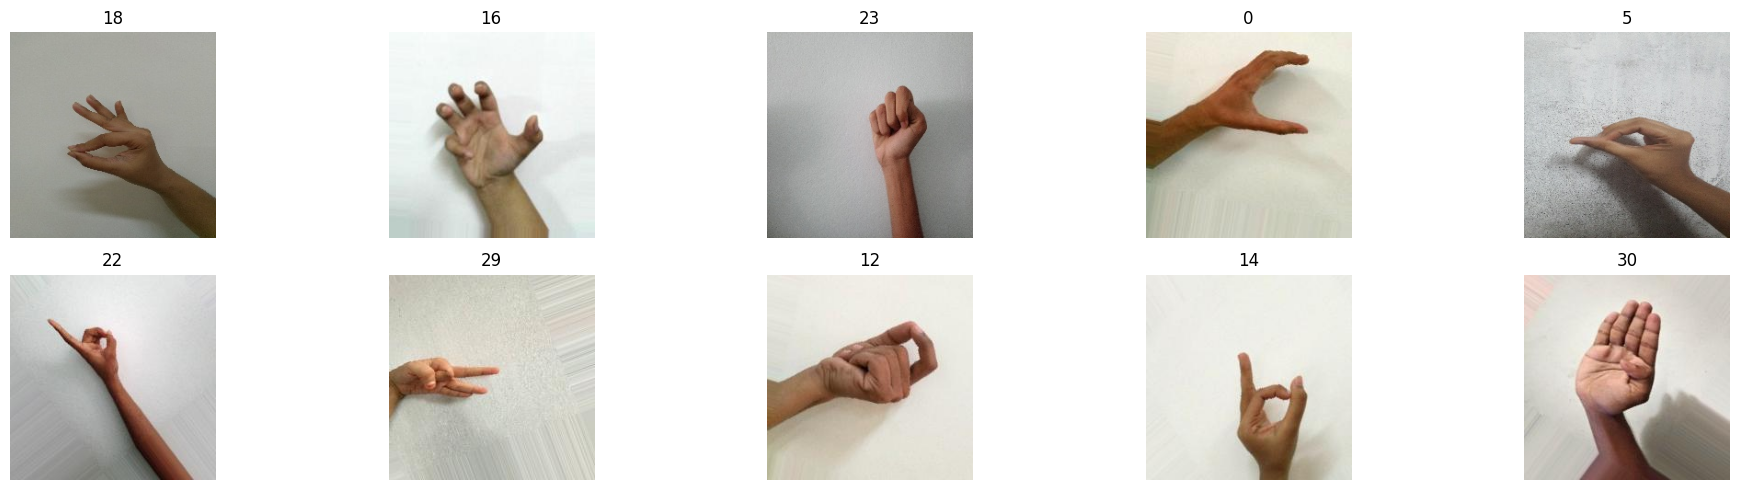

In [17]:
import matplotlib.image as mpimg

# List of subdirectories (classes)
class_dirs = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]

# Total number of classes
num_classes = len(class_dirs)
num_cols = (num_classes + 1) // 2  # ensure even layout
num_rows = 2

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(4 * num_cols, 5))

# Flatten axes for easy indexing
axes = axes.flatten()

# Loop through each class and plot one image
for idx, class_name in enumerate(class_dirs):
    class_path = os.path.join(train_dir, class_name)
    image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    if image_files:
        img_path = os.path.join(class_path, image_files[0])
        img = Image.open(img_path)

        axes[idx].imshow(img)
        axes[idx].set_title(class_name)
        axes[idx].axis('off')

# Hide any extra axes if number of classes is odd
for j in range(len(class_dirs), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

# Task 2: Design, Train, and Evaluate a Baseline Convolutional Neural Network

In [18]:
# Parameters
batch_size = 32
num_classes = 10

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='sparse',
    seed=42
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False,
    seed=42
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False,
    seed=42
)
input_shape=(224, 224, 3)

Found 10485 images belonging to 10 classes.
Found 570 images belonging to 10 classes.
Found 289 images belonging to 10 classes.


In [19]:
# Baseline CNN model
model = Sequential([
    Input(shape = input_shape),
    # Conv Layer 1
    Conv2D(32, (3, 3), padding='same', activation='relu'),
    MaxPooling2D((2, 2)),
    # Conv Layer 2
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    MaxPooling2D((2, 2)),
    # Conv Layer 3
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    MaxPooling2D((2, 2)),
    # Flatten
    Flatten(),
    # FCN 1
    Dense(512, activation='relu'),
    # FCN 2
    Dense(256, activation='relu'),
    # FCN 3
    Dense(128, activation='relu'),
    # Output Layer
    Dense(num_classes, activation='softmax')
])

# Compile model
model.compile(optimizer=Adam(learning_rate=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

I0000 00:00:1746763091.902613      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1746763091.903321      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      51,380,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 51,639,498 (196.99 MB)

 Trainable params: 51,639,498 (196.99 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
callbacks=[
            tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
            tf.keras.callbacks.ModelCheckpoint(f'basemodel_cnn_model.keras', monitor='val_accuracy', save_best_only=True),
            tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)
]
# Training time 
start_time_cnn = time.time()

# Train model
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks= callbacks
)
train_time_cnn = time.time() - start_time_cnn

Epoch 1/20
328/328 ━━━━━━━━━━━━━━━━━━━━ 116s 347ms/step - accuracy: 0.1135 - loss: 2.4271 - val_accuracy: 0.2246 - val_loss: 2.1138 - learning_rate: 0.0010
Epoch 2/20
328/328 ━━━━━━━━━━━━━━━━━━━━ 110s 327ms/step - accuracy: 0.1981 - loss: 2.1586 - val_accuracy: 0.2947 - val_loss: 1.9229 - learning_rate: 0.0010
Epoch 3/20
328/328 ━━━━━━━━━━━━━━━━━━━━ 109s 324ms/step - accuracy: 0.2954 - loss: 1.8878 - val_accuracy: 0.5351 - val_loss: 1.2905 - learning_rate: 0.0010
Epoch 4/20
328/328 ━━━━━━━━━━━━━━━━━━━━ 109s 326ms/step - accuracy: 0.4737 - loss: 1.4336 - val_accuracy: 0.6842 - val_loss: 0.9065 - learning_rate: 0.0010
Epoch 5/20
328/328 ━━━━━━━━━━━━━━━━━━━━ 108s 322ms/step - accuracy: 0.6090 - loss: 1.1255 - val_accuracy: 0.7842 - val_loss: 0.6987 - learning_rate: 0.0010
Epoch 6/20
328/328 ━━━━━━━━━━━━━━━━━━━━ 108s 322ms/step - accuracy: 0.6786 - loss: 0.9261 - val_accuracy: 0.8263 - val_loss: 0.5434 - learning_rate: 0.0010
Epoch 7/20
328/328 ━━━━━━━━━━━━━━━━━━━━ 108s 321ms/step - accura

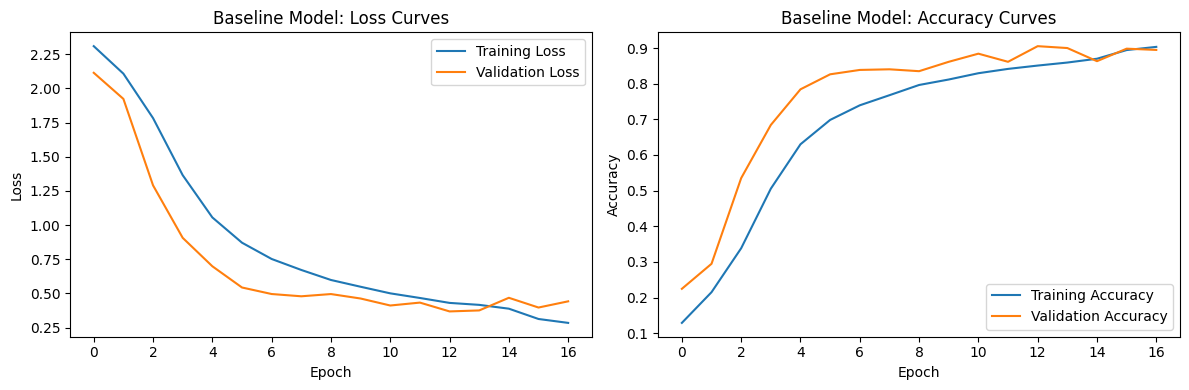

In [22]:
# Plot training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Baseline Model: Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Baseline Model: Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.savefig('baseline_loss_accuracy.png')
plt.show()
plt.close()

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8876 - loss: 0.4268
Baseline Model - Test Loss: 0.3951, Test Accuracy: 0.8858, Training time: 1840.86 seconds
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step

Baseline Model Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.93      0.89        29
          12       1.00      0.93      0.96        28
          14       0.76      0.81      0.79        27
          16       0.90      0.93      0.92        30
          18       0.86      0.66      0.75        29
          22       0.87      0.90      0.89        30
          23       0.84      0.93      0.89        29
          29       1.00      0.90      0.95        29
          30       0.91      1.00      0.95        29
           5       0.89      0.86      0.88        29

    accuracy                           0.89       289
   macro avg       0.89      0.89      0.88       289
weighted avg       0.89      0.89      0.88       289

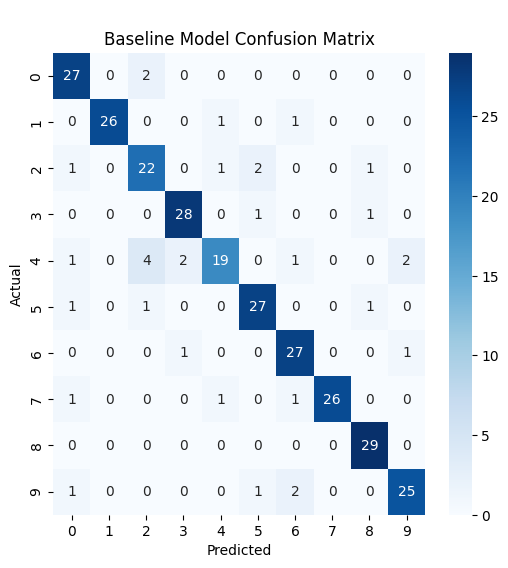

In [27]:
import seaborn as sns
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Baseline Model - Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Training time: {train_time_cnn:.2f} seconds")

# Detailed metrics
test_predictions = model.predict(test_generator)
test_pred_labels = np.argmax(test_predictions, axis=1)
test_true_labels = test_generator.classes
print("\nBaseline Model Classification Report:")
print(classification_report(test_true_labels, test_pred_labels, target_names=list(test_generator.class_indices.keys())))

# Confusion matrix
cm = confusion_matrix(test_true_labels, test_pred_labels)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('\nBaseline Model Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step


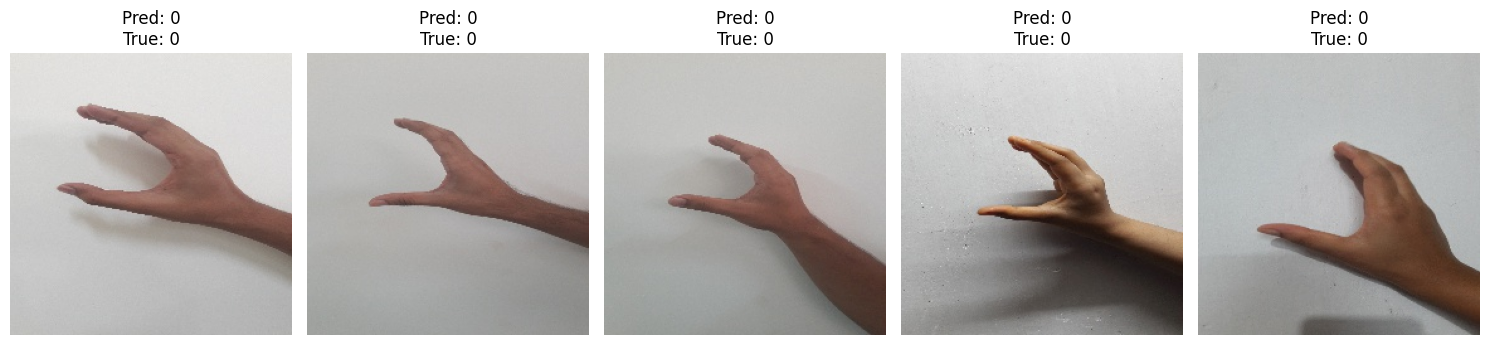

In [30]:
loaded_model = tf.keras.models.load_model('basemodel_cnn_model.keras')

# Inference on sample test images
sample_images, sample_labels = next(test_generator)
sample_predictions = loaded_model.predict(sample_images)
sample_pred_labels = np.argmax(sample_predictions, axis=1)
class_names = list(test_generator.class_indices.keys())

plt.figure(figsize=(15, 5))
for i in range(5):  # Show 5 sample predictions
    plt.subplot(1, 5, i+1)
    plt.imshow(sample_images[i])
    plt.title(f"Pred: {class_names[sample_pred_labels[i]]}\nTrue: {class_names[int(sample_labels[i])]}")
    plt.axis('off')
plt.tight_layout()
plt.show()
plt.close()

Found 289 images belonging to 10 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


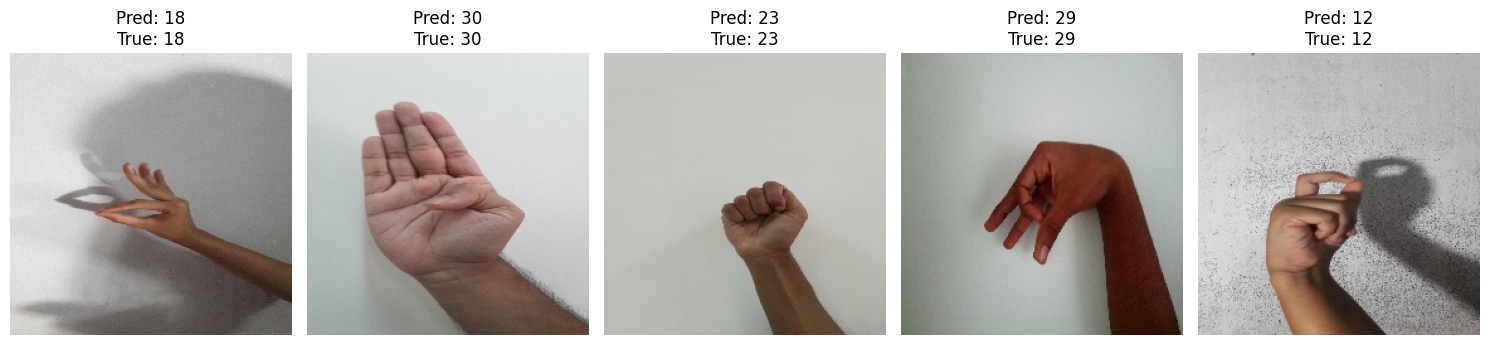

In [31]:
import random

# Shuffle the generator manually to pick more diverse data
test_generator_shuffled = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='sparse',
    shuffle=True,
    seed=None  # No fixed seed this time
)

sample_images, sample_labels = next(test_generator_shuffled)

sample_predictions = loaded_model.predict(sample_images)
sample_pred_labels = np.argmax(sample_predictions, axis=1)
class_names = list(test_generator.class_indices.keys())

plt.figure(figsize=(15, 5))
for i in range(5):  # Show 5 sample predictions
    plt.subplot(1, 5, i+1)
    plt.imshow(sample_images[i])
    plt.title(f"Pred: {class_names[sample_pred_labels[i]]}\nTrue: {class_names[int(sample_labels[i])]}")
    plt.axis('off')
plt.tight_layout()
plt.show()
plt.close()

# Task 3: Design, Train, and Evaluate a Deeper Convolutional Neural Network Architecture with Regularization Layer

In [32]:
from tensorflow.keras.layers import BatchNormalization, Dropout, Activation
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
import time

input_shape=(img_height, img_width, 3)

# Deeper CNN model
model = Sequential([
    Input(shape = input_shape),
    # Conv Layer 1
    Conv2D(32, (3, 3), padding='same', activation=None, kernel_regularizer=l2(1e-4)),
    BatchNormalization(momentum=0.9),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    # Conv Layer 2
    Conv2D(64, (3, 3),  padding='same',activation=None, kernel_regularizer=l2(1e-4)),
    BatchNormalization(momentum=0.9),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    # Conv Layer 3
    Conv2D(128, (3, 3), padding='same', activation=None, kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    # Conv Layer 4
    Conv2D(256, (3, 3),  padding='same', activation=None, kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    # Conv Layer 5
    Conv2D(256, (3, 3), padding='same', activation=None, kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    # Conv Layer 6
    Conv2D(512, (3, 3),  padding='same', activation=None, kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    # Flatten
    Flatten(),
    # FCN 1
    Dense(1024, activation='relu', kernel_regularizer=l2(1e-4)),
    Dropout(0.5),
    # FCN 2
    Dense(512, activation='relu', kernel_regularizer=l2(1e-4)),
    Dropout(0.5),
    # FCN 3
    Dense(512, activation='relu', kernel_regularizer=l2(1e-4)),
    # FCN 4
    Dense(256, activation='relu', kernel_regularizer=l2(1e-4)),
    # FCN 5
    Dense(256, activation='relu', kernel_regularizer=l2(1e-4)),
    # FCN 6
    Dense(128, activation='relu', kernel_regularizer=l2(1e-4)),
    # Output Layer
    Dense(num_classes, activation='softmax', kernel_regularizer=l2(1e-4))
])

# Model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 224, 224, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 28, 28, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 14, 14, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 14, 14, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 14, 14, 256)         │              

 Total params: 7,902,026 (30.14 MB)

 Trainable params: 7,899,530 (30.13 MB)

 Non-trainable params: 2,496 (9.75 KB)

In [35]:
# Function to train and evaluate with a given optimizer
def train_and_evaluate(optimizer, optimizer_name):
    print(f"\nTraining with {optimizer_name}...")
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    start_time = time.time()
    history = model.fit(
        train_generator,
        epochs=20,
        validation_data=val_generator,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
            tf.keras.callbacks.ModelCheckpoint(f'deeper_cnn_{optimizer_name.lower()}.keras', monitor='val_accuracy', save_best_only=True),
            tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)

        ]
    )
    training_time = time.time() - start_time
    
    # Plot loss and accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Deeper Model ({optimizer_name}): Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Deeper Model ({optimizer_name}): Accuracy Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'deeper_loss_accuracy_{optimizer_name.lower()}.png')
    plt.show()
    plt.close()
    
    # Evaluate on test set
    test_loss, test_accuracy = model.evaluate(test_generator)
    print(f"Deeper Model ({optimizer_name}) - Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Training Time: {training_time:.2f} seconds")
    
    # Detailed metrics
    test_predictions = model.predict(test_generator)
    test_pred_labels = np.argmax(test_predictions, axis=1)
    test_true_labels = test_generator.classes
    print(f"\nDeeper Model ({optimizer_name}) Classification Report:")
    print(classification_report(test_true_labels, test_pred_labels, target_names=list(test_generator.class_indices.keys())))
    
    return test_loss, test_accuracy, training_time


Training with Adam...
Epoch 1/20
328/328 ━━━━━━━━━━━━━━━━━━━━ 130s 346ms/step - accuracy: 0.1075 - loss: 2.4444 - val_accuracy: 0.1035 - val_loss: 2.3896 - learning_rate: 0.0010
Epoch 2/20
328/328 ━━━━━━━━━━━━━━━━━━━━ 108s 323ms/step - accuracy: 0.2058 - loss: 2.1054 - val_accuracy: 0.2018 - val_loss: 2.0865 - learning_rate: 0.0010
Epoch 3/20
328/328 ━━━━━━━━━━━━━━━━━━━━ 108s 321ms/step - accuracy: 0.3070 - loss: 1.7229 - val_accuracy: 0.3140 - val_loss: 1.7806 - learning_rate: 0.0010
Epoch 4/20
328/328 ━━━━━━━━━━━━━━━━━━━━ 108s 321ms/step - accuracy: 0.4730 - loss: 1.3291 - val_accuracy: 0.4351 - val_loss: 1.8021 - learning_rate: 0.0010
Epoch 5/20
328/328 ━━━━━━━━━━━━━━━━━━━━ 107s 320ms/step - accuracy: 0.5804 - loss: 1.0775 - val_accuracy: 0.7474 - val_loss: 0.7499 - learning_rate: 0.0010
Epoch 6/20
328/328 ━━━━━━━━━━━━━━━━━━━━ 108s 321ms/step - accuracy: 0.6690 - loss: 0.8809 - val_accuracy: 0.8246 - val_loss: 0.5303 - learning_rate: 0.0010
Epoch 7/20
328/328 ━━━━━━━━━━━━━━━━━━━━ 1

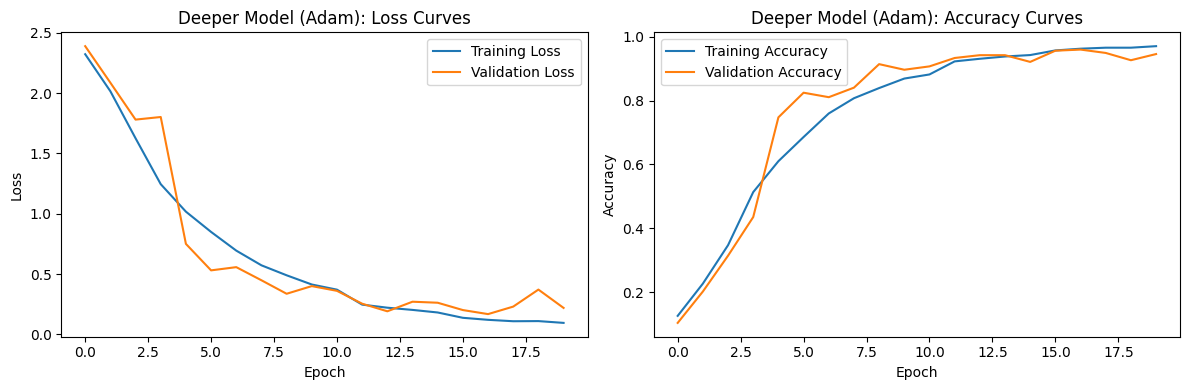

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 0.9643 - loss: 0.1377
Deeper Model (Adam) - Test Loss: 0.1616, Test Accuracy: 0.9550, Training Time: 2179.75 seconds
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step

Deeper Model (Adam) Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        29
          12       0.96      0.96      0.96        28
          14       0.87      0.96      0.91        27
          16       1.00      1.00      1.00        30
          18       0.96      0.86      0.91        29
          22       1.00      0.97      0.98        30
          23       0.93      0.93      0.93        29
          29       1.00      0.97      0.98        29
          30       0.94      1.00      0.97        29
           5       0.93      0.90      0.91        29

    accuracy                           0.96       289
   macro avg       0.96      0.95      0.95       289
weighted avg       0.96      0.96      0.

In [36]:
# Train with Adam
adam_loss, adam_accuracy, adam_time = train_and_evaluate(Adam(learning_rate=1e-3), "Adam")

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.9750 - loss: 0.1400
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step


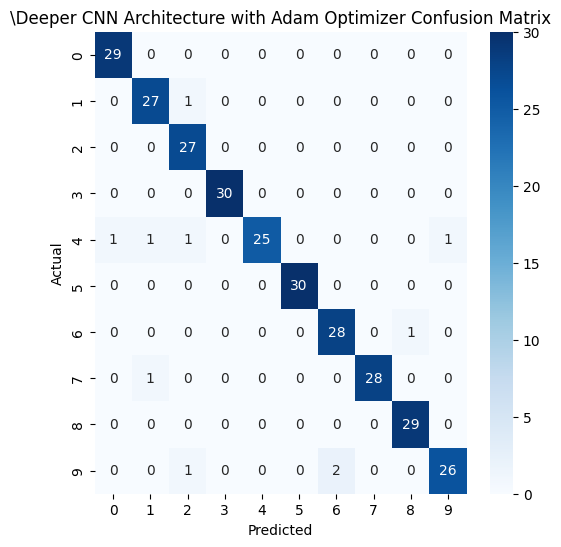

In [40]:
loaded_model = tf.keras.models.load_model('deeper_cnn_adam.keras')

# Evaluate on test set
test_loss, test_accuracy = model.evaluate(test_generator)
    
# Detailed metrics
test_predictions = model.predict(test_generator)
test_pred_labels = np.argmax(test_predictions, axis=1)
test_true_labels = test_generator.classes

# Confusion matrix
cm = confusion_matrix(test_true_labels, test_pred_labels)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Deeper CNN Architecture with Adam Optimizer Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Training with SGD...
Epoch 1/20
328/328 ━━━━━━━━━━━━━━━━━━━━ 120s 333ms/step - accuracy: 0.1164 - loss: 2.3527 - val_accuracy: 0.1333 - val_loss: 2.2962 - learning_rate: 0.0010
Epoch 2/20
328/328 ━━━━━━━━━━━━━━━━━━━━ 108s 322ms/step - accuracy: 0.1400 - loss: 2.2829 - val_accuracy: 0.2982 - val_loss: 2.0469 - learning_rate: 0.0010
Epoch 3/20
328/328 ━━━━━━━━━━━━━━━━━━━━ 109s 326ms/step - accuracy: 0.2160 - loss: 2.1210 - val_accuracy: 0.3596 - val_loss: 1.7564 - learning_rate: 0.0010
Epoch 4/20
328/328 ━━━━━━━━━━━━━━━━━━━━ 109s 326ms/step - accuracy: 0.3514 - loss: 1.7235 - val_accuracy: 0.5088 - val_loss: 1.3676 - learning_rate: 0.0010
Epoch 5/20
328/328 ━━━━━━━━━━━━━━━━━━━━ 108s 323ms/step - accuracy: 0.4379 - loss: 1.4781 - val_accuracy: 0.3982 - val_loss: 1.6509 - learning_rate: 0.0010
Epoch 6/20
328/328 ━━━━━━━━━━━━━━━━━━━━ 109s 326ms/step - accuracy: 0.5242 - loss: 1.2565 - val_accuracy: 0.6158 - val_loss: 1.0189 - learning_rate: 0.0010
Epoch 7/20
328/328 ━━━━━━━━━━━━━━━━━━━━ 11

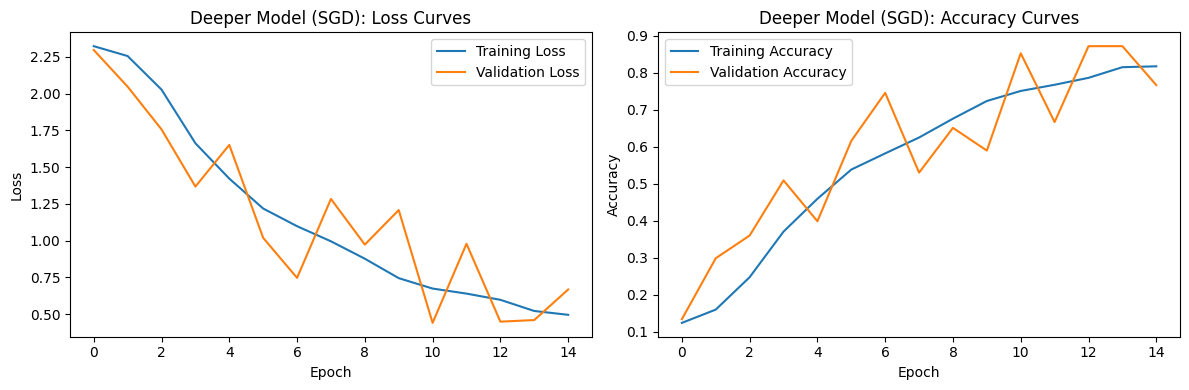

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.8212 - loss: 0.4784
Deeper Model (SGD) - Test Loss: 0.4527, Test Accuracy: 0.8408, Training Time: 1640.44 seconds
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step

Deeper Model (SGD) Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.90      0.93        29
          12       0.92      0.82      0.87        28
          14       0.60      0.56      0.58        27
          16       1.00      0.93      0.97        30
          18       0.85      0.59      0.69        29
          22       0.71      0.90      0.79        30
          23       0.84      0.93      0.89        29
          29       0.84      0.93      0.89        29
          30       0.78      1.00      0.88        29
           5       0.96      0.83      0.89        29

    accuracy                           0.84       289
   macro avg       0.85      0.84      0.84       289
weighted avg       0.85      0.84      0.84 

In [41]:
# Rebuild model for SGD (to reset weights)
model = Sequential([  # Same architecture as above
    Input(shape = input_shape),
    # Conv Layer 1
    Conv2D(32, (3, 3), padding='same', activation=None, kernel_regularizer=l2(1e-4)),
    BatchNormalization(momentum=0.9),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    # Conv Layer 2
    Conv2D(64, (3, 3),  padding='same',activation=None, kernel_regularizer=l2(1e-4)),
    BatchNormalization(momentum=0.9),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    # Conv Layer 3
    Conv2D(128, (3, 3), padding='same', activation=None, kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    # Conv Layer 4
    Conv2D(256, (3, 3),  padding='same', activation=None, kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    # Conv Layer 5
    Conv2D(256, (3, 3), padding='same', activation=None, kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    # Conv Layer 6
    Conv2D(512, (3, 3),  padding='same', activation=None, kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    # Flatten
    Flatten(),
    # FCN 1
    Dense(1024, activation='relu', kernel_regularizer=l2(1e-4)),
    Dropout(0.5),
    # FCN 2
    Dense(512, activation='relu', kernel_regularizer=l2(1e-4)),
    Dropout(0.5),
    # FCN 3
    Dense(512, activation='relu', kernel_regularizer=l2(1e-4)),
    # FCN 4
    Dense(256, activation='relu', kernel_regularizer=l2(1e-4)),
    # FCN 5
    Dense(256, activation='relu', kernel_regularizer=l2(1e-4)),
    # FCN 6
    Dense(128, activation='relu', kernel_regularizer=l2(1e-4)),
    # Output Layer
    Dense(num_classes, activation='softmax', kernel_regularizer=l2(1e-4))
])
    
# Train with SGD
sgd_loss, sgd_accuracy, sgd_time = train_and_evaluate(SGD(learning_rate=1e-3, momentum=0.9), "SGD")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8212 - loss: 0.4784
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


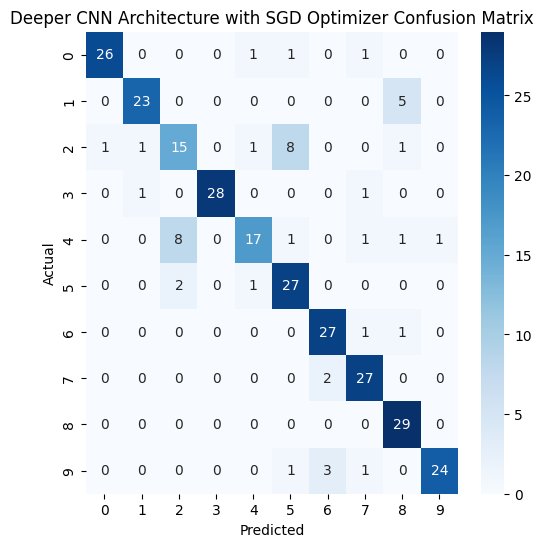

In [42]:
loaded_model = tf.keras.models.load_model('deeper_cnn_sgd.keras')

# Evaluate on test set
test_loss, test_accuracy = model.evaluate(test_generator)
    
# Detailed metrics
test_predictions = model.predict(test_generator)
test_pred_labels = np.argmax(test_predictions, axis=1)
test_true_labels = test_generator.classes

# Confusion matrix
cm = confusion_matrix(test_true_labels, test_pred_labels)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Deeper CNN Architecture with SGD Optimizer Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [43]:
# Compare optimizers
print("\nOptimizer Comparison:")
print(f"Adam - Test Loss: {adam_loss:.4f}, Test Accuracy: {adam_accuracy:.4f}, Training Time: {adam_time:.2f} seconds")
print(f"SGD - Test Loss: {sgd_loss:.4f}, Test Accuracy: {sgd_accuracy:.4f}, Training Time: {sgd_time:.2f} seconds")


Optimizer Comparison:
Adam - Test Loss: 0.1616, Test Accuracy: 0.9550, Training Time: 2179.75 seconds
SGD - Test Loss: 0.4527, Test Accuracy: 0.8408, Training Time: 1640.44 seconds


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 706ms/step


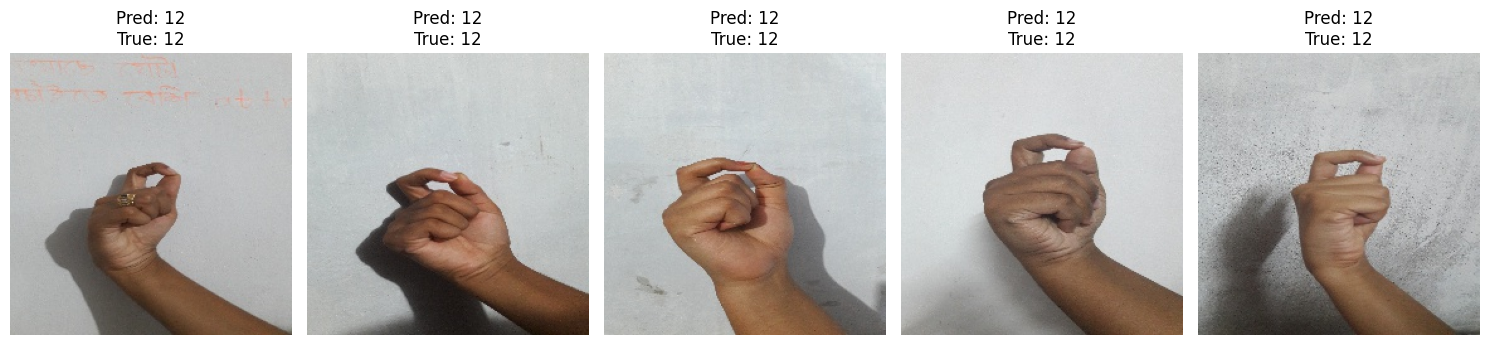

In [44]:
# Load best model (Adam or SGD based on test accuracy)
best_model_file = 'deeper_cnn_adam.keras' if adam_accuracy >= sgd_accuracy else 'deeper_cnn_sgd.keras'
model = tf.keras.models.load_model(best_model_file)

# Inference on sample test images
sample_images, sample_labels = next(test_generator)
sample_predictions = model.predict(sample_images)
sample_pred_labels = np.argmax(sample_predictions, axis=1)
class_names = list(test_generator.class_indices.keys())

plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(sample_images[i])
    plt.title(f"Pred: {class_names[sample_pred_labels[i]]}\nTrue: {class_names[int(sample_labels[i])]}")
    plt.axis('off')
plt.tight_layout()
plt.savefig('deeper_sample_predictions.png')
plt.show()
plt.close()

Found 289 images belonging to 10 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


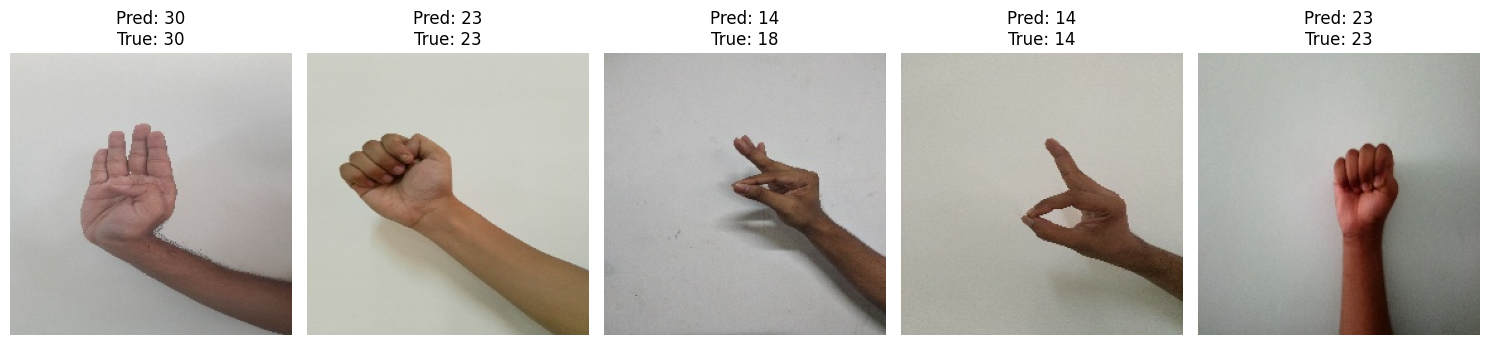

In [46]:
# Inference on sample test images
import random

# Shuffle the generator manually to pick more diverse data
test_generator_shuffled = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='sparse',
    shuffle=True,
    seed=None  # No fixed seed this time
)

sample_images, sample_labels = next(test_generator_shuffled)
sample_predictions = model.predict(sample_images)
sample_pred_labels = np.argmax(sample_predictions, axis=1)
class_names = list(test_generator.class_indices.keys())

plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(sample_images[i])
    plt.title(f"Pred: {class_names[sample_pred_labels[i]]}\nTrue: {class_names[int(sample_labels[i])]}")
    plt.axis('off')
plt.tight_layout()
plt.savefig('deeper_sample_predictions.png')
plt.show()
plt.close()

# Task 4: Fine-Tuning a Pre-Trained Model (Transfer Learning)

# ResNet50

In [50]:
import requests
try:
    response = requests.get('https://storage.googleapis.com/tensorflow/keras-applications/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', timeout=10)
    print(f"Connection successful, status code: {response.status_code}")
except Exception as e:
    print(f"Connection failed: {e}")

Connection successful, status code: 200


In [51]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
# Load ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_model.trainable = False  # Freeze base model

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile model for feature extraction
model.compile(optimizer=Adam(learning_rate=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

Model: "functional_117"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 24,641,930 (94.00 MB)

 Trainable params: 1,054,218 (4.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [52]:
# Train model (feature extraction)
print("Training with feature extraction...")
start_time = time.time()
history_fe = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint('resnet50_fe.keras', monitor='val_accuracy', save_best_only=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)
    ]
)
fe_time = time.time() - start_time

Training with feature extraction...
Epoch 1/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 130s 350ms/step - accuracy: 0.1019 - loss: 2.4118 - val_accuracy: 0.1140 - val_loss: 2.3024 - learning_rate: 0.0010
Epoch 2/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 108s 324ms/step - accuracy: 0.1030 - loss: 2.3007 - val_accuracy: 0.0982 - val_loss: 2.3030 - learning_rate: 0.0010
Epoch 3/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 108s 323ms/step - accuracy: 0.0981 - loss: 2.3025 - val_accuracy: 0.1000 - val_loss: 2.3020 - learning_rate: 0.0010
Epoch 4/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 108s 321ms/step - accuracy: 0.1082 - loss: 2.3019 - val_accuracy: 0.1000 - val_loss: 2.3038 - learning_rate: 0.0010
Epoch 5/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - accuracy: 0.0990 - loss: 2.3018
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
328/328 ━━━━━━━━━━━━━━━━━━━━ 107s 320ms/step - accuracy: 0.0990 - loss: 2.3018 - val_accuracy: 0.1000 - val_loss: 2.3040 - learning_rate: 0.0010
Epoch 6/10
328/328 ━━━━━━━━━━━━

In [53]:
# Fine-tuning
base_model.trainable = True
for layer in base_model.layers[:100]:  # Freeze first 100 layers
    layer.trainable = False

# Recompile with lower learning rate
model.compile(optimizer=Adam(learning_rate=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train model (fine-tuning)
print("Training with fine-tuning...")
start_time = time.time()
history_ft = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint('resnet50_ft.keras', monitor='val_accuracy', save_best_only=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
    ]
)
ft_time = time.time() - start_time

Training with fine-tuning...
Epoch 1/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 164s 377ms/step - accuracy: 0.1731 - loss: 2.2553 - val_accuracy: 0.4316 - val_loss: 1.8409 - learning_rate: 1.0000e-05
Epoch 2/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 111s 332ms/step - accuracy: 0.3475 - loss: 1.7890 - val_accuracy: 0.5947 - val_loss: 1.2274 - learning_rate: 1.0000e-05
Epoch 3/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 111s 331ms/step - accuracy: 0.4565 - loss: 1.5066 - val_accuracy: 0.6947 - val_loss: 0.8688 - learning_rate: 1.0000e-05
Epoch 4/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 111s 332ms/step - accuracy: 0.5547 - loss: 1.2883 - val_accuracy: 0.7368 - val_loss: 0.8045 - learning_rate: 1.0000e-05
Epoch 5/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 110s 329ms/step - accuracy: 0.5938 - loss: 1.1685 - val_accuracy: 0.7158 - val_loss: 0.7836 - learning_rate: 1.0000e-05
Epoch 6/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 112s 333ms/step - accuracy: 0.6481 - loss: 1.0404 - val_accuracy: 0.7544 - val_loss: 0.6773 - learning_rate: 1.0000e-05
Epoch 7/10


In [54]:
# Combine histories for plotting
history = {
    'loss': history_fe.history['loss'] + history_ft.history['loss'],
    'val_loss': history_fe.history['val_loss'] + history_ft.history['val_loss'],
    'accuracy': history_fe.history['accuracy'] + history_ft.history['accuracy'],
    'val_accuracy': history_fe.history['val_accuracy'] + history_ft.history['val_accuracy']
}

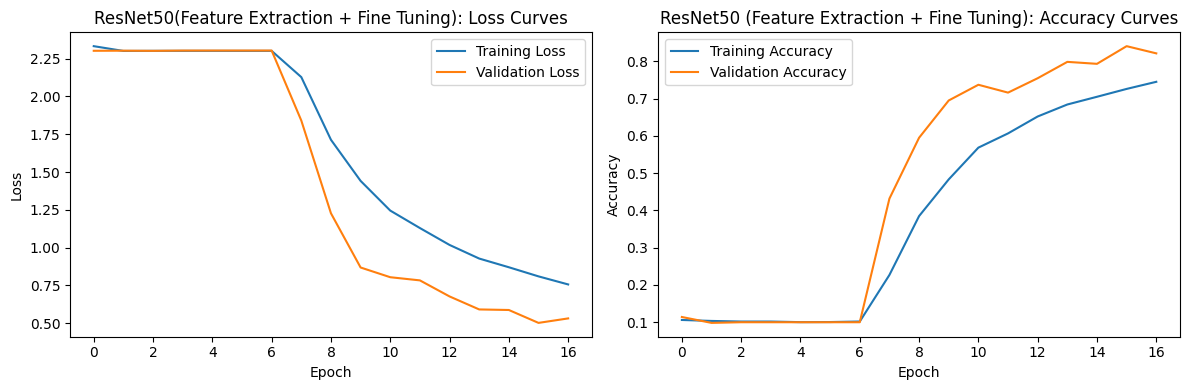

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.8165 - loss: 0.5288
ResNet50 - Test Loss: 0.5648, Test Accuracy: 0.7993, Total Training Time: 1946.28 seconds
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step

ResNet50 Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.86      0.89        29
          12       0.58      0.79      0.67        28
          14       0.71      0.89      0.79        27
          16       0.84      0.87      0.85        30
          18       0.84      0.72      0.78        29
          22       1.00      0.63      0.78        30
          23       0.68      0.86      0.76        29
          29       1.00      0.93      0.96        29
          30       0.77      0.79      0.78        29
           5       0.90      0.66      0.76        29

    accuracy                           0.80       289
   macro avg       0.82      0.80      0.80       289
weighted avg       0.83      0.80      0.80       289



In [67]:
# Plot loss and accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('ResNet50(Feature Extraction + Fine Tuning): Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('ResNet50 (Feature Extraction + Fine Tuning): Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.savefig('resnet50_loss_accuracy.png')
plt.show()
plt.close()

# Evaluate on test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"ResNet50 - Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Total Training Time: {fe_time + ft_time:.2f} seconds")

# Detailed metrics
test_predictions = model.predict(test_generator)
test_pred_labels = np.argmax(test_predictions, axis=1)
test_true_labels = test_generator.classes
print("\nResNet50 Classification Report:")
print(classification_report(test_true_labels, test_pred_labels, target_names=list(test_generator.class_indices.keys())))


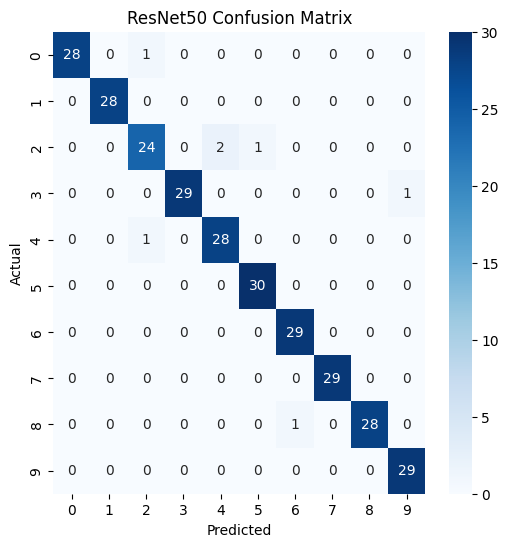

In [76]:
# Confusion matrix
cm = confusion_matrix(test_true_labels, test_pred_labels)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('ResNet50 Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


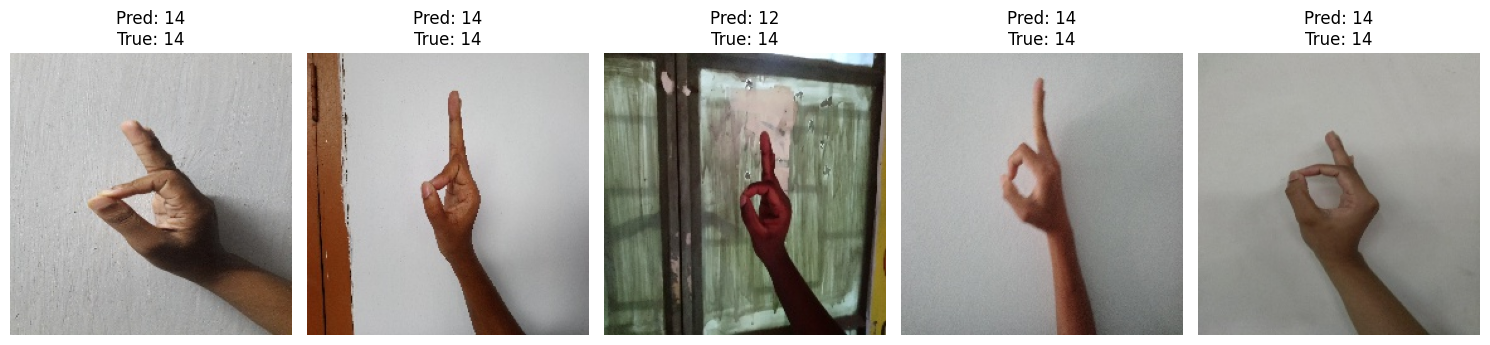

In [56]:
# Save final model
model.save('resnet50_final.keras')

# Inference on sample test images
sample_images, sample_labels = next(test_generator)
sample_predictions = model.predict(sample_images)
sample_pred_labels = np.argmax(sample_predictions, axis=1)
class_names = list(test_generator.class_indices.keys())

plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(sample_images[i])
    plt.title(f"Pred: {class_names[sample_pred_labels[i]]}\nTrue: {class_names[int(sample_labels[i])]}")
    plt.axis('off')
plt.tight_layout()
plt.savefig('resnet50_sample_predictions.png')
plt.show()
plt.close()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


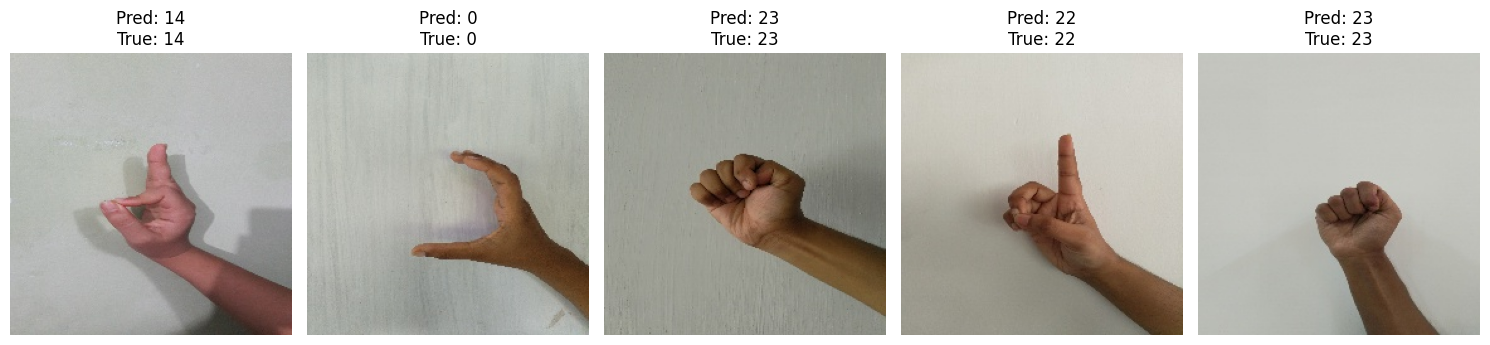

In [57]:
# Inference on sample test images
sample_images, sample_labels = next(test_generator_shuffled)
sample_predictions = model.predict(sample_images)
sample_pred_labels = np.argmax(sample_predictions, axis=1)
class_names = list(test_generator.class_indices.keys())

plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(sample_images[i])
    plt.title(f"Pred: {class_names[sample_pred_labels[i]]}\nTrue: {class_names[int(sample_labels[i])]}")
    plt.axis('off')
plt.tight_layout()
plt.savefig('resnet50_sample_predictions.png')
plt.show()
plt.close()

In [58]:
original_path = '/kaggle/input/signlanguagedetection/Sign Language Classification/Test'
test_dir = '/kaggle/working/signlanguagedetection/Sign Language Classification/TestOriginal'
if os.path.exists(test_dir):
    shutil.rmtree(test_dir)
shutil.copytree(original_path,test_dir)

'/kaggle/working/signlanguagedetection/Sign Language Classification/TestOriginal'

In [59]:
# Predict original three test images (if available)
def load_test_images(test_dir, img_height, img_width):
    test_images = []
    test_filenames = os.listdir(test_dir)
    for filename in test_filenames:
        img_path = os.path.join(test_dir, filename)
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(img_height, img_width))
        img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
        test_images.append(img_array)
    return np.array(test_images), test_filenames

original_test_dir = '/kaggle/working/signlanguagedetection/Sign Language Classification/TestOriginal'
if os.path.exists(original_test_dir):
    test_images, test_filenames = load_test_images(original_test_dir, img_height, img_width)
    predictions = model.predict(test_images)
    pred_labels = np.argmax(predictions, axis=1)
    print("\nResNet50 Predictions on Original Test Images:")
    for filename, label in zip(test_filenames, pred_labels):
        print(f"Image: {filename}, Predicted: {class_names[label]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step

ResNet50 Predictions on Original Test Images:
Image: 20180625_230047.jpg, Predicted: 14
Image: 20180625_203333.jpg, Predicted: 29
Image: 20180701_194331.jpg, Predicted: 0


In [60]:
baseline_cnn_model = tf.keras.models.load_model('basemodel_cnn_model.keras')
test_images, test_filenames = load_test_images(original_test_dir, img_height, img_width)
predictions = baseline_cnn_model.predict(test_images)
pred_labels = np.argmax(predictions, axis=1)
print("\nBaseline CNN Predictions on Original Test Images:")
for filename, label in zip(test_filenames, pred_labels):
    print(f"Image: {filename}, Predicted: {class_names[label]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 966ms/step

Baseline CNN Predictions on Original Test Images:
Image: 20180625_230047.jpg, Predicted: 0
Image: 20180625_203333.jpg, Predicted: 29
Image: 20180701_194331.jpg, Predicted: 0


In [62]:
deeper_adam_cnn_model = tf.keras.models.load_model('deeper_cnn_adam.keras')
test_images, test_filenames = load_test_images(original_test_dir, img_height, img_width)
predictions = deeper_adam_cnn_model.predict(test_images)
pred_labels = np.argmax(predictions, axis=1)
print("\nDeeper CNN (Adam) Predictions on Original Test Images:")
for filename, label in zip(test_filenames, pred_labels):
    print(f"Image: {filename}, Predicted: {class_names[label]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

Deeper CNN (Adam) Predictions on Original Test Images:
Image: 20180625_230047.jpg, Predicted: 14
Image: 20180625_203333.jpg, Predicted: 29
Image: 20180701_194331.jpg, Predicted: 0


In [65]:
deeper_sgd_cnn_model = tf.keras.models.load_model('deeper_cnn_sgd.keras')
test_images, test_filenames = load_test_images(original_test_dir, img_height, img_width)
predictions = deeper_sgd_cnn_model.predict(test_images)
pred_labels = np.argmax(predictions, axis=1)
print("\nDeeper CNN (SGD) Predictions on Original Test Images:")
for filename, label in zip(test_filenames, pred_labels):
    print(f"Image: {filename}, Predicted: {class_names[label]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 715ms/step

Deeper CNN (SGD) Predictions on Original Test Images:
Image: 20180625_230047.jpg, Predicted: 0
Image: 20180625_203333.jpg, Predicted: 29
Image: 20180701_194331.jpg, Predicted: 0


# InceptionV3

In [68]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model

weights_path_inceptionv3 = '/kaggle/input/inceptionv3_weights/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.keras'

# Image parameters
img_height, img_width = 224, 224
batch_size = 32
num_classes = 10

# Verify GPU
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Load InceptionV3 with cached or internet weights
try:
    if os.path.exists(weights_path_inceptionv3):
        print("Loading local InceptionV3 weights...")
        base_model = InceptionV3(weights=None, include_top=False, input_shape=(img_height, img_width, 3))
        base_model.load_weights(weights_path_inceptionv3)
    else:
        print("Downloading InceptionV3 weights from internet...")
        base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
except Exception as e:
    print(f"Failed to load InceptionV3 weights: {e}")
    print("Ensure internet is enabled or weights are available locally.")
    raise

base_model.trainable = False  # Freeze base model

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model_inceptionv3 = Model(inputs=base_model.input, outputs=predictions)

# Model summary
model_inceptionv3.summary()

# Compile model for feature extraction
model_inceptionv3.compile(optimizer=Adam(learning_rate=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Num GPUs Available:  2
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_265"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_15 (Conv2D)        │ (None, 111, 111, 32)   │            864 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_12    │ (None, 111, 111, 32)   │             96 │ conv2d_15[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_12             │ (None, 111, 111, 32)   │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_16 (Conv2D)        │ (None, 109, 109, 32)   │          9,216 │ activation_12[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_13    │ (None, 109, 109, 32)   │             96 │ conv2d_16[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_13             │ (None, 109, 109, 32)   │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_17 (Conv2D)        │ (None, 109, 109, 64)   │         18,432 │ activation_13[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_14    │ (None, 109, 109, 64)   │            192 │ conv2d_17[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_14             │ (None, 109, 109, 64)   │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_15          │ (None, 54, 54, 64)     │              0 │ activation_14[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_18 (Conv2D)        │ (None, 54, 54, 80)     │          5,120 │ max_pooling2d_15[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_15    │ (None, 54, 54, 80)     │            240 │ conv2d_18[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_15             │ (None, 54, 54, 80)     │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_19 (Conv2D)   

 Total params: 22,857,002 (87.19 MB)

 Trainable params: 1,054,218 (4.02 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [69]:
# Train model (feature extraction)
print("Training with feature extraction...")
start_time_fe = time.time()
history_fe = model_inceptionv3.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint('inceptionv3_fe.keras', monitor='val_accuracy', save_best_only=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)
    ]
)
fe_time_inceptionv3 = time.time() - start_time_fe

Training with feature extraction...
Epoch 1/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 149s 389ms/step - accuracy: 0.5076 - loss: 1.5072 - val_accuracy: 0.8491 - val_loss: 0.4751 - learning_rate: 0.0010
Epoch 2/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 109s 325ms/step - accuracy: 0.7288 - loss: 0.7823 - val_accuracy: 0.8702 - val_loss: 0.4133 - learning_rate: 0.0010
Epoch 3/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 108s 322ms/step - accuracy: 0.7754 - loss: 0.6608 - val_accuracy: 0.8596 - val_loss: 0.4049 - learning_rate: 0.0010
Epoch 4/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 109s 325ms/step - accuracy: 0.7792 - loss: 0.6390 - val_accuracy: 0.8860 - val_loss: 0.3767 - learning_rate: 0.0010
Epoch 5/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 109s 324ms/step - accuracy: 0.7989 - loss: 0.5877 - val_accuracy: 0.8807 - val_loss: 0.3616 - learning_rate: 0.0010
Epoch 6/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 108s 322ms/step - accuracy: 0.8069 - loss: 0.5704 - val_accuracy: 0.8807 - val_loss: 0.3985 - learning_rate: 0.0010
Epoch 7/10
328/328 ━━━━━━━━━

In [70]:
# Fine-tuning
base_model.trainable = True
for layer in base_model.layers[:200]:  # Freeze first 200 layers (InceptionV3 has ~311 layers)
    layer.trainable = False

# Recompile with lower learning rate
model_inceptionv3.compile(optimizer=Adam(learning_rate=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train model (fine-tuning)
print("Training with fine-tuning...")
start_time_ft = time.time()
history_ft = model_inceptionv3.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint('inceptionv3_ft.keras', monitor='val_accuracy', save_best_only=True)
    ]
)
ft_time_inceptionv3 = time.time() - start_time_ft

Training with fine-tuning...
Epoch 1/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 173s 398ms/step - accuracy: 0.7052 - loss: 0.8882 - val_accuracy: 0.9211 - val_loss: 0.2678
Epoch 2/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 111s 330ms/step - accuracy: 0.8892 - loss: 0.3483 - val_accuracy: 0.9298 - val_loss: 0.2157
Epoch 3/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 112s 335ms/step - accuracy: 0.9221 - loss: 0.2391 - val_accuracy: 0.9351 - val_loss: 0.1809
Epoch 4/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 113s 336ms/step - accuracy: 0.9400 - loss: 0.1885 - val_accuracy: 0.9526 - val_loss: 0.1556
Epoch 5/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 111s 330ms/step - accuracy: 0.9485 - loss: 0.1459 - val_accuracy: 0.9579 - val_loss: 0.1485
Epoch 6/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 112s 334ms/step - accuracy: 0.9663 - loss: 0.1060 - val_accuracy: 0.9614 - val_loss: 0.1480
Epoch 7/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 110s 328ms/step - accuracy: 0.9690 - loss: 0.1032 - val_accuracy: 0.9614 - val_loss: 0.1453
Epoch 8/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 112s 33

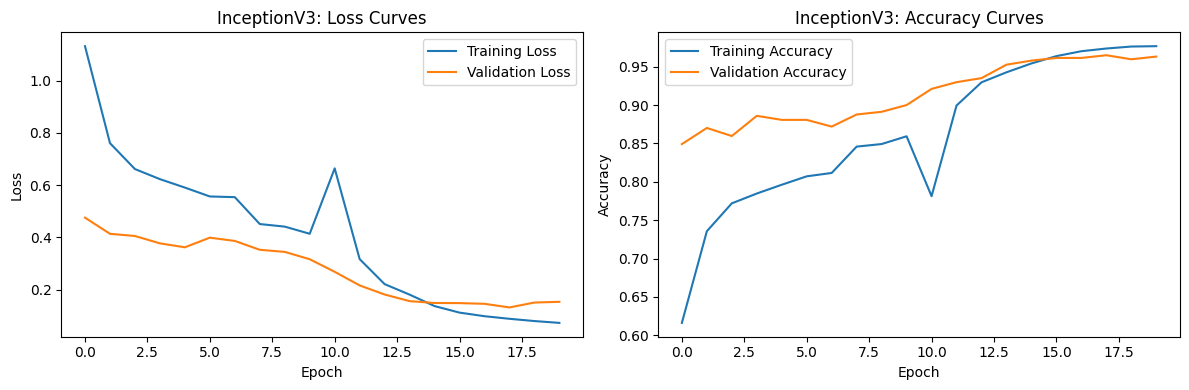

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.9685 - loss: 0.1779
InceptionV3 - Test Loss: 0.1343, Test Accuracy: 0.9758, Total Training Time: 2306.24 seconds
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step

InceptionV3 Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        29
          12       1.00      1.00      1.00        28
          14       0.92      0.89      0.91        27
          16       1.00      0.97      0.98        30
          18       0.93      0.97      0.95        29
          22       0.97      1.00      0.98        30
          23       0.97      1.00      0.98        29
          29       1.00      1.00      1.00        29
          30       1.00      0.97      0.98        29
           5       0.97      1.00      0.98        29

    accuracy                           0.98       289
   macro avg       0.98      0.98      0.98       289
weighted avg       0.98      0.98      0.98       289

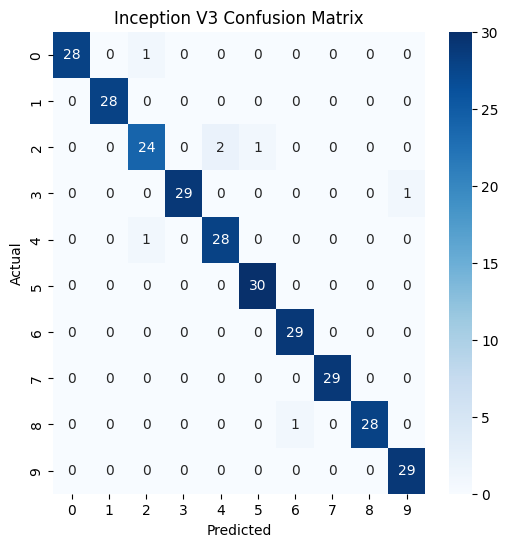

In [75]:
# Combine histories for plotting
history = {
    'loss': history_fe.history['loss'] + history_ft.history['loss'],
    'val_loss': history_fe.history['val_loss'] + history_ft.history['val_loss'],
    'accuracy': history_fe.history['accuracy'] + history_ft.history['accuracy'],
    'val_accuracy': history_fe.history['val_accuracy'] + history_ft.history['val_accuracy']
}
# Plot loss and accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('InceptionV3: Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('InceptionV3: Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.savefig('inceptionv3_loss_accuracy.png')
plt.show()
plt.close()

# Evaluate on test set
test_loss, test_accuracy = model_inceptionv3.evaluate(test_generator)
print(f"InceptionV3 - Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Total Training Time: {fe_time_inceptionv3 + ft_time_inceptionv3:.2f} seconds")

# Detailed metrics
test_predictions = model_inceptionv3.predict(test_generator)
test_pred_labels = np.argmax(test_predictions, axis=1)
test_true_labels = test_generator.classes
print("\nInceptionV3 Classification Report:")
print(classification_report(test_true_labels, test_pred_labels, target_names=list(test_generator.class_indices.keys())))

# Confusion matrix
cm = confusion_matrix(test_true_labels, test_pred_labels)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Inception V3 Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
plt.close()
# Save final model
model_inceptionv3.save('inceptionv3_final.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


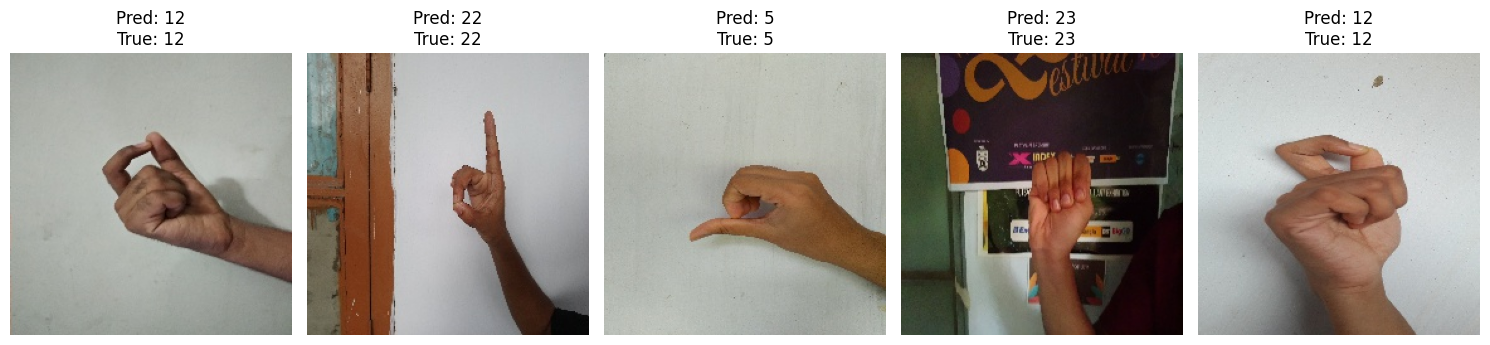

In [73]:
# Inference on sample test images
sample_images, sample_labels = next(test_generator_shuffled)
sample_predictions = model_inceptionv3.predict(sample_images)
sample_pred_labels = np.argmax(sample_predictions, axis=1)
class_names = list(test_generator.class_indices.keys())

plt.figure(figsize=(15, 5))
for i in range():
    plt.subplot(1, 5, i+1)
    plt.imshow(sample_images[i])
    plt.title(f"Pred: {class_names[sample_pred_labels[i]]}\nTrue: {class_names[int(sample_labels[i])]}")
    plt.axis('off')
plt.tight_layout()
plt.savefig('inceptionv3_sample_predictions.png')
plt.show()
plt.close()

In [77]:
test_images, test_filenames = load_test_images(original_test_dir, img_height, img_width)
predictions = model_inceptionv3.predict(test_images)
pred_labels = np.argmax(predictions, axis=1)
print("\nInception V3 Predictions on Original Test Images:")
for filename, label in zip(test_filenames, pred_labels):
    print(f"Image: {filename}, Predicted: {class_names[label]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

Inception V3 Predictions on Original Test Images:
Image: 20180625_230047.jpg, Predicted: 14
Image: 20180625_203333.jpg, Predicted: 29
Image: 20180701_194331.jpg, Predicted: 0
